<a href="https://colab.research.google.com/github/julianikulski/director-experience/blob/main/analysis/exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA
In this notebook, the director sample dataset will be merged with the control variables and the dependent variable and the datasets will be explored and prepared for the regression analysis.

This notebook will also serve as a reference for determining the entire universe of companies and directors I started out with and how this universe was reduced because of missing or incomplete data. This notebook is the source for almost all data, tables, and figures mentioned in chapter 4 and 5.1 of the thesis.

In [1]:
# connecting to Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from glob import glob
import os
from datetime import datetime
from functools import reduce

from scipy.stats import mannwhitneyu, shapiro, pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize

import seaborn as sb
import matplotlib.pyplot as plt

%matplotlib inline


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# set number of max rows
pd.set_option('display.max_rows', 1000)


In [4]:
# palette for boxplots
palette = sb.color_palette('Set3', 15)
palette


[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (1.0, 0.9294117647058824, 0.43529411764705883),
 (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137)]

# Determine the sample size

In [5]:
# read in the founding year file because this includes the all companies which
# were a part of the S&P 500 index for at least one of the years between 2011 and 2016
founding_year_df = pd.read_csv('/content/drive/My Drive/director-csr/control_variables/founding_year.csv')


In [6]:
# create a new column with the ticker in lower case
founding_year_df['ticker'] = founding_year_df['Instrument'].apply(lambda x: x.lower().split('.')[0])
founding_year_df.head()


,Instrument,Organization Founded Year,RIC,Company Name,ISIN Code,2016,2015,2014,2013,2012,2011,2010,ticker
0,MMM.N,1929,MMM.N,3M Co,US88579Y1010,2016.0,2015.0,2014.0,2013.0,2012.0,2011.0,2010.0,mmm
1,ABT.N,1900,ABT.N,Abbott Laboratories,US0028241000,2016.0,2015.0,2014.0,2013.0,2012.0,2011.0,2010.0,abt
2,ABBV.N,2012,ABBV.N,Abbvie Inc,US00287Y1091,2016.0,2015.0,2014.0,2013.0,NaN,NaN,NaN,abbv
3,ACN.N,2009,ACN.N,Accenture PLC,IE00B4BNMY34,2016.0,2015.0,2014.0,2013.0,2012.0,2011.0,NaN,acn
4,ATVI.OQ,2000,ATVI.OQ,Activision Blizzard Inc,US00507V1098,2016.0,2015.0,NaN,NaN,NaN,NaN,NaN,atvi


In [7]:
# Number of entries in this dataframe
founding_year_df.shape


(630, 13)

In [8]:
# remove the year 2010 from the dataframe
founding_year_df.drop(columns=['2010'], inplace=True)


In [9]:
# drop all companies from 
founding_year_df.dropna(subset=['2016', '2015', '2014', '2013', '2012', '2011'], how='all', inplace=True)
founding_year_df.shape


(610, 12)

In [10]:
# duplicate company entries based on different isins
dupe_comps = founding_year_df[(founding_year_df.duplicated(subset='Company Name', keep=False)) & (founding_year_df['Company Name'].notnull())]['Company Name']
# unique companies in original dataset
print('Number of companies in original sample:', founding_year_df.shape[0] - len(dupe_comps.unique()))


Number of companies in original sample: 606


There were 606 unique companies included in the S&P 500 index between 2011 and 2016. However, a number of these companies were delisted, left the index and did not have any data on their board membership. Thus, these companies had to be excluded.

In [11]:
# save all delisted companies
delisted_comps_df = founding_year_df[founding_year_df['Instrument'].str.contains('\^')].copy()


In [12]:
# get the number of companies that had 
all_files = glob('/content/drive/My Drive/director-csr/directors_firms/*.xlsx')

all_comps_list = []
for file in all_files:
    ticker = os.path.basename(file).split('_')[0]
    all_comps_list.append(ticker)

unique_comps = list(set(all_comps_list))
unique_comps = [x.lower() for x in unique_comps]

print('Number of companies with director data:', len(unique_comps))


Number of companies with director data: 490


In [13]:
# which companies are not included in the founding_year_df
list(set(unique_comps) - set(founding_year_df['ticker']))


['0ieo', 'ftc', 'itt', 'ftrcq', 'bpyu', 'chkaq', 'dofsq', 'cta', 'mdp']

Out of the 606 different companies in the relevant time frame, only 487 companies had data related to board membership on Refinitiv Eikon. Data on 490 companies was available, however, 3 of those (namely those with the tickers ftc, itt, and mdp) were irrelevant because they were not a part of the S&P 500 in the relevant years (between 2011 and 2015). ftc was not a part of the S&P 500 at all (and I apparently made a mistake by downloading this data) and mdp and itt were only part of the S&P500 in 2010. After closer examination and review of biographies, even fewer companies were left in the final sample.


In [14]:
# read in the file that includes all relevant directors
all_directors_rel = pd.read_csv('/content/drive/My Drive/director-csr/all_directors_rel.csv')
all_directors_rel.shape


(6888, 25)

In [15]:
# remove the three tickers which were not part of the S&P 500 between 2011 and 2015
remove_tickers = ['ftc', 'itt', 'mdp']
all_directors_rel = all_directors_rel[~all_directors_rel['ticker'].isin(remove_tickers)]
all_directors_rel.shape


(6870, 25)

In [16]:
# number of unique directors contained in the original dataframe
print(all_directors_rel['unique_dir_id'].nunique())


5491


These 487 companies had 6888 directors on their boards between 2011 and 2015. This includes 5,491 unique directors. The biographical data from the S&P Capital IQ dataset was merged with the director dataset, leading to 1,395 unique biographies being assigned to unique directors (this is shown in the `biography_matching.ipynb` notebook). The remaining 4,096 biographies had to be researched in DEF 14A forms of the respective companies. The S&P Capital IQ dataset included 38,827 entries and 32,424 unique directors and their biographies (this is shown in the `csr_experience_ETL.ipynb` notebook).

In [17]:
# read in the complete_sample file
complete_sample_df = pd.read_excel('/content/drive/My Drive/director-csr/complete_sample.xlsx')
complete_sample_df.drop(columns=['Unnamed: 0'], inplace=True)
print(complete_sample_df.shape)
complete_sample_df.head()


(6595, 34)


,name,age,last_position,director_start,director_end,executive_start,executive_end,comp_name,ticker,missing_start_date,2011,2012,2013,2014,2015,current_position,dir_exec,in_position,isin,org_name,unique_dir_id,all_years,biographies,board_committee,committee,comm_type,comm_start,comm_end,list_years_if_non_consecutive,2011_comm,2012_comm,2013_comm,2014_comm,2015_comm
0,christina gold,72.0,independent director,0.0,0.0,1997.0,2020.0,itt inc,itt,0.0,1,1,1,1,1,NaN,NaN,NaN,us45073v1089,ms. christina gold,7917,no,Mrs. Christina A. Gold has been the Chief Exec...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
1,frank macinnis,72.0,independent chairman of the board,2011.0,2020.0,2001.0,2020.0,itt inc,itt,0.0,1,1,1,1,1,NaN,NaN,NaN,us45073v1089,mr. frank macinnis,3325,no,Mr. Frank T. MacInnis serves as the President ...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
2,denise ramos,63.0,"president, chief executive officer, director",2011.0,2019.0,2011.0,2019.0,itt inc,itt,0.0,1,1,1,1,1,NaN,NaN,NaN,us45073v1089,ms. denise ramos,7996,no,Ms. Denise L. Ramos serves as the Chief Execut...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
3,orlando ashford,51.0,NaN,NaN,NaN,NaN,NaN,itt inc,itt,NaN,0,1,1,1,1,independent director,2012.0,2012.0,us45073v1089,mr. orlando ashford,5733,no,"Orlando D. Ashford, 47, has served as the Pres...",NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
4,donald defosset,72.0,NaN,NaN,NaN,NaN,NaN,itt inc,itt,NaN,0,1,1,1,1,independent director,2012.0,2012.0,us45073v1089,"mr. donald (don) defosset , jr.",2984,no,"Mr. Donald DeFosset, Jr., also known as Don, B...",NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0


In [18]:
# remove the irrelevant tickers
complete_sample_df = complete_sample_df[~complete_sample_df['ticker'].isin(remove_tickers)]
complete_sample_df.shape


(6577, 34)

In [19]:
# total number of unique directors included in the dataset
len(complete_sample_df['unique_dir_id'].unique())


5311

In [20]:
# get the number of unique companies
unique_comps_name = list(complete_sample_df['comp_name'].unique())
unique_comps_isin = list(complete_sample_df['isin'].unique())
len(unique_comps_isin)


467

Only 467 companies had enough director data to be included in the final sample. **Now, the dependent and the control variables need to be investigated to see whether further companies need to be excluded.** The total number of unique directors sitting on these 467 company boards is 5,311. 

# Dependent variables
I will have two different dependent variables. One environmental and one social variable. Everything else I can drop. I will split the environmental environmental and social variable into two different dataframes and then merge the control variables into these dataframes, relating to the particular year. Then I will know how many company-year combinations I will have in my overall sample. Moreover, I will know which companies I need to include for my director biography classifications. Hopefully, some of the companies with longer biographies can be kicked out because this would reduce my GPU memory issues during the training phase of my Longformer model.


In [21]:
# read in the csr score data fields by Reuters
csr_scores_df = pd.read_csv('/content/drive/My Drive/director-csr/dependent_variables/csr_scores.csv')
csr_scores_df.sort_values(by=['Instrument', 'year_score'])


,Instrument,Environmental Pillar Score,Social Pillar Score,Governance Pillar Score,ESG Score,ESG Controversies Score,ESG Combined Score,Fiscal Year End Date,Company Name,ISIN Code,year_score
14,A.N,78.041206,89.422378,64.079336,78.408873,89.285714,78.408873,2021-10-31,Agilent Technologies Inc,US00846U1016,2011
644,A.N,78.131785,90.984662,58.558687,77.179638,100.000000,77.179638,2021-10-31,Agilent Technologies Inc,US00846U1016,2012
1274,A.N,74.607396,91.037209,59.730073,77.034437,100.000000,77.034437,2021-10-31,Agilent Technologies Inc,US00846U1016,2013
1904,A.N,72.351190,88.852760,81.051157,83.283059,95.238095,83.283059,2021-10-31,Agilent Technologies Inc,US00846U1016,2014
2534,A.N,72.144397,87.491916,69.653997,78.509846,100.000000,78.509846,2021-10-31,Agilent Technologies Inc,US00846U1016,2015
...,...,...,...,...,...,...,...,...,...,...,...
1135,ZTS.N,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31,Zoetis Inc,US98978V1035,2012
1765,ZTS.N,20.741653,39.170777,76.128144,46.433568,100.000000,46.433568,2021-12-31,Zoetis Inc,US98978V1035,2013
2395,ZTS.N,21.116243,38.960855,32.016814,32.755320,100.000000,32.755320,2021-12-31,Zoetis Inc,US98978V1035,2014
3025,ZTS.N,25.445382,44.837462,28.707768,35.434537,100.000000,35.434537,2021-12-31,Zoetis Inc,US98978V1035,2015


In [22]:
# create a new column with the ticker in lower case
csr_scores_df['ticker'] = csr_scores_df['Instrument'].apply(lambda x: x.lower().split('.')[0])
# change the column names
csr_scores_df.rename(columns={'Environmental Pillar Score': 'env_score',
                              'Social Pillar Score': 'soc_score',
                              'Company Name': 'comp_name', 
                              'ISIN Code': 'isin'}, inplace=True)
# turn comp_name and isin into lower case
csr_scores_df['comp_name'] = csr_scores_df['comp_name'].apply(lambda x: x.lower() if not pd.isna(x) else x)
csr_scores_df['isin'] = csr_scores_df['isin'].apply(lambda x: x.lower() if not pd.isna(x) else x)


In [23]:
# number of unique companies with an environmental score
not_only_2011 = csr_scores_df[csr_scores_df['year_score'] != '2011']
len(list(not_only_2011[not_only_2011['env_score'].notnull()]['ticker'].unique()))


604

From these 604 companies, there are a number of companies which were only part of the S&P 500 in 2010. Therefore, I will have to remove these irrelevant companies later on. After I have handled all the missing values for the control and independent variables, I need to compare the distributions between my final sample and this technically relevant sample of 604 companies minus any companies which were only part of the S&P 500 index in 2010. These distributions should not be statistically significantly different. However, this will be handled further done in the notebook.

In [24]:
# create environmental score dataframe
env_score_df = csr_scores_df[['ticker', 'comp_name', 'isin', 'env_score',
                              'year_score']].copy()

print(env_score_df.shape)
env_score_df.head()


(3780, 5)


,ticker,comp_name,isin,env_score,year_score
0,mmm,3m co,us88579y1010,84.273026,2011
1,abt,abbott laboratories,us0028241000,54.215270,2011
2,abbv,abbvie inc,us00287y1091,NaN,2011
3,acn,accenture plc,ie00b4bnmy34,78.276816,2011
4,atvi,activision blizzard inc,us00507v1098,0.000000,2011


In [25]:
# create social score dataframe
soc_score_df = csr_scores_df[['ticker', 'comp_name', 'isin', 'soc_score',
                              'year_score']].copy()

print(soc_score_df.shape)
soc_score_df.head()


(3780, 5)


,ticker,comp_name,isin,soc_score,year_score
0,mmm,3m co,us88579y1010,87.935154,2011
1,abt,abbott laboratories,us0028241000,91.631630,2011
2,abbv,abbvie inc,us00287y1091,NaN,2011
3,acn,accenture plc,ie00b4bnmy34,81.830393,2011
4,atvi,activision blizzard inc,us00507v1098,16.358999,2011


In [26]:
# remove all entries from year 2011 as these will only be required as a control variable
env_score_no_2011_df = env_score_df[env_score_df['year_score'] != 2011].copy()
soc_score_no_2011_df = soc_score_df[soc_score_df['year_score'] != 2011].copy()


In [27]:
# drop any rows that have a missing score
env_score_no_2011_df.dropna(subset=['env_score'], inplace=True)
print('available environmental score samples:', env_score_no_2011_df.shape)
soc_score_no_2011_df.dropna(subset=['soc_score'], inplace=True)
print('available social score samples:', soc_score_no_2011_df.shape)


available environmental score samples: (2831, 5)
available social score samples: (2831, 5)


In total, there are 2831 company-year observations. However, I now need to remove any companies from this dataset which do not have any director information. Moreover, the dataframes `env_score_no_2011_df` and `soc_score_no_2011_df` need to be investigated further later on to check whether the companies which do not have biographical data and board composition information are statistically different from the companies that will be included in my final sample.

In [28]:
# remove any sample which are not in the director dataframe
env_score_dep_df = env_score_no_2011_df[env_score_no_2011_df['isin'].isin(unique_comps_isin)]
print(env_score_dep_df.shape)
soc_score_dep_df = soc_score_no_2011_df[soc_score_no_2011_df['isin'].isin(unique_comps_isin)]
print(soc_score_dep_df.shape)


(2284, 5)
(2284, 5)


In [29]:
# companies included in the sample
unique_comps = list(soc_score_dep_df['isin'].unique())
# which companies are not included in the director dataset
dir_data_but_no_score = list(set(unique_comps_isin) - set(unique_comps))
dir_data_but_no_score


['us98310w1080', 'us0374111054']

In [30]:
# number of companies included in the sample before considering control variable issues
len(unique_comps)


465

In [31]:
# get the number of total directors included in those 465 companies
complete_sample_avail_score = complete_sample_df[~complete_sample_df['isin'].isin(dir_data_but_no_score)].copy()
complete_sample_avail_score.shape


(6551, 34)

In [32]:
# get the number of unique directors included in those 465 companies
len(complete_sample_avail_score['unique_dir_id'].unique())


5287

In [33]:
# write this to a csv file so that it can be used by the notebook that predicts 
# the experience with the longformer model
complete_sample_avail_score.to_csv('/content/drive/My Drive/director-csr/complete_sample_avail_score.csv')


This means based on the data availability of the dependent variable and the independent variable, there are a total 465 companies in my 2,284 company-year-observation sample with 5,287 unique directors included in this dataset. **However, I will need to check whether any further companies need to be excluded because of any missing values in the control variables or independent variables later on.**

# Independent variable
The independent variable will be constructed by reading in the `predicted_bios.csv` file and match those bios to the directors in the `complete_sample_no_missing` dataframe. Additionally, the biographies that were reviewed for the training sample will replace the predicted biographies. I did not exclude these from the dataset that was predicted, but will do this now.

Then the board score will be calculated and the committee score will be calculated as well.

## Add predicted CSR experience board score to dataframes

In [34]:
# read in all predicted bios
predicted_bios_df = pd.read_csv('/content/drive/My Drive/director-csr/predicted_bios.csv')
predicted_bios_df.drop(columns=['Unnamed: 0'], inplace=True)
predicted_bios_df.head()


,bio,social,environmental
0,"Mr. James F. McCann, also known as Jim, Founde...",1,0
1,"Mr. Ubben, age 54, joined the Willis Towers Wa...",0,0
2,"Mr. Casserley, age 58, has served as President...",0,0
3,"Sir Roy Gardner, age 69, joined the Board on A...",0,0
4,"Sir Jeremy Hanley, age 69, joined the Board on...",0,0


In [35]:
# read in the reviewed bios
all_rev_df = pd.read_csv('/content/drive/My Drive/director-csr/review_data/all_200_rev.csv')
all_rev_df.drop(columns=['Unnamed: 0'], inplace=True)
all_rev_df.head()


,bio,social,environmental
0,"Mr. Matthew E. Massengill, also known as Matt,...",1,1
1,"Mr. Michael H. Dilger, also known as Mick, has...",0,0
2,Mr. John R. Hislop has been Chief Executive Of...,0,0
3,Mr. John F. Coyne served as the Chief Executiv...,0,0
4,"Mr. John J. Koraleski, also known as Jack, ser...",1,0


In [36]:
# merge both biography datasets
merged_bios_df = pd.merge(predicted_bios_df, all_rev_df, how='left', on='bio', suffixes=['_predicted', '_reviewed'])
merged_bios_df.head()


,bio,social_predicted,environmental_predicted,social_reviewed,environmental_reviewed
0,"Mr. James F. McCann, also known as Jim, Founde...",1,0,NaN,NaN
1,"Mr. Ubben, age 54, joined the Willis Towers Wa...",0,0,NaN,NaN
2,"Mr. Casserley, age 58, has served as President...",0,0,NaN,NaN
3,"Sir Roy Gardner, age 69, joined the Board on A...",0,0,NaN,NaN
4,"Sir Jeremy Hanley, age 69, joined the Board on...",0,0,NaN,NaN


In [37]:
# how many reviewed biographies are in the final director dataset
merged_bios_df[merged_bios_df['social_reviewed'].notnull()].shape


(110, 5)

From the 200 reviewed biographies, only 110 were in the final dataset because the selection of the to-be-reviewed samples was done before the director dataset was compiled. This had to be done because there were data procurement issues regarding the board composition and director names and tenures of the companies in the dataset.

In [38]:
# replace the predicted with the reviewed bios
merged_bios_df['social_predicted'] = merged_bios_df.apply(lambda x: int(x['social_reviewed']) 
                                                                    if not pd.isna(x['social_reviewed'])
                                                                    else x['social_predicted'], axis=1)
merged_bios_df['environmental_predicted'] = merged_bios_df.apply(lambda x: int(x['environmental_reviewed'])
                                                                    if not pd.isna(x['environmental_reviewed'])
                                                                    else x['environmental_predicted'], axis=1)


In [39]:
# drop the environmental and social reviewed columns
merged_bios_df.drop(columns=['social_reviewed', 'environmental_reviewed'], inplace=True)
merged_bios_df.rename(columns={'social_predicted': 'social', 
                               'environmental_predicted': 'environmental'}, inplace=True)
merged_bios_df.head()


,bio,social,environmental
0,"Mr. James F. McCann, also known as Jim, Founde...",1,0
1,"Mr. Ubben, age 54, joined the Willis Towers Wa...",0,0
2,"Mr. Casserley, age 58, has served as President...",0,0
3,"Sir Roy Gardner, age 69, joined the Board on A...",0,0
4,"Sir Jeremy Hanley, age 69, joined the Board on...",0,0


In [40]:
# check how many occurences of environmental, social and both tags appear in the dataset
def show_share(df):
    '''
    Function to show the share of occurences of classes in the dataframe
    Args: df = dataframe with classes
    Returns: df_share = dataframe containing shares
    '''
    df_share = df.groupby(['environmental', 'social'], as_index=False).count()
    df_share['share'] = df_share.apply(lambda x: x['bio'] / len(df), axis=1)
    
    return df_share
    

In [41]:
# show the proportions of labels of the final biographies dataset
show_share(merged_bios_df)


,environmental,social,bio,share
0,0,0,3788,0.717560
1,0,1,549,0.103997
2,1,0,3,0.000568
3,1,1,939,0.177875


**This is not the reported share in the thesis because I predicted khc but I need to remove this because it did not have all control variables**. Further done in chapter "Adjust the complete director sample by removing any dropped companies" I will report the correct share.

In [42]:
# merge the labels with the director sample
complete_sample_avail_score.rename(columns={'biographies': 'bio'}, inplace=True)
directors_classified_df = pd.merge(complete_sample_avail_score, merged_bios_df, how='left', on='bio')
directors_classified_df.head()


,name,age,last_position,director_start,director_end,executive_start,executive_end,comp_name,ticker,missing_start_date,2011,2012,2013,2014,2015,current_position,dir_exec,in_position,isin,org_name,unique_dir_id,all_years,bio,board_committee,committee,comm_type,comm_start,comm_end,list_years_if_non_consecutive,2011_comm,2012_comm,2013_comm,2014_comm,2015_comm,social,environmental
0,james mccann,68.0,independent director,0.0,0.0,2004.0,2019.0,willis towers watson plc,wltw,0.0,1,1,1,1,1,NaN,NaN,NaN,ie00bdb6q211,"mr. james mccann , iii",4129,no,"Mr. James F. McCann, also known as Jim, Founde...",NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1.0,0.0
1,jeffrey ubben,58.0,independent director,0.0,0.0,2013.0,2017.0,willis towers watson plc,wltw,0.0,0,0,1,1,1,NaN,NaN,NaN,ie00bdb6q211,mr. jeffrey (jeff) ubben,4249,no,"Mr. Ubben, age 54, joined the Willis Towers Wa...",NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0.0,0.0
2,dominic casserley,58.0,"president, deputy chief executive officer, dir...",2013.0,2016.0,2013.0,2016.0,willis towers watson plc,wltw,0.0,0,0,1,1,1,NaN,NaN,NaN,ie00bdb6q211,mr. dominic casserley,2968,no,"Mr. Casserley, age 58, has served as President...",NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0.0,0.0
3,sir roy gardner,NaN,independent director,0.0,0.0,2006.0,2015.0,willis towers watson plc,wltw,0.0,1,1,1,1,1,NaN,NaN,NaN,ie00bdb6q211,sir roy gardner,9219,no,"Sir Roy Gardner, age 69, joined the Board on A...",NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0.0,0.0
4,sir jeremy hanley,72.0,independent director,0.0,0.0,2006.0,2015.0,willis towers watson plc,wltw,0.0,1,1,1,1,1,NaN,NaN,NaN,ie00bdb6q211,sir jeremy hanley,9202,no,"Sir Jeremy Hanley, age 69, joined the Board on...",NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0.0,0.0


In [43]:
# create two new columns specifying individually whether a company has a social or an environmental committee
directors_classified_df['social_comm'] = directors_classified_df['comm_type'].apply(lambda x: 1 if not pd.isna(x) and 'social' in x else 0)
directors_classified_df['environmental_comm'] = directors_classified_df['comm_type'].apply(lambda x: 1 if not pd.isna(x) and 'environment' in x else 0)


In [44]:
def create_experience_score(df, committee=None):
    '''
    Function to create experience scores for each company and each year, 
    either for the entire board or for the respective committee
    Args: df = dataframe
          committee = boolean; indicates whether the score for the committee 
                        should be calculated
    Returns: merged_df = dataframe with all board scores
    '''
    # define years and labels
    if committee:
        # the years that relate to the membership in a committee
        years_comm = ['2011_comm', '2012_comm', '2013_comm', '2014_comm', '2015_comm']
        # the labels that relate to the type of committee
        labels_comm = ['social_comm', 'environmental_comm']

    # the years that relate to the membership on the board 
    years = ['2011', '2012', '2013', '2014', '2015']
    # the labels that relate to the experience
    labels = ['social', 'environmental']

    # list to save the created dataframes
    all_labels = []

    # for each label and each year, group the directors per company and sum
    # the experience flags
    for i in range(len(labels)):
        # list to save all years for one label
        all_years = []

        for j in range(len(years)):
            # two different approaches based on whether this relates to the committee or the overall board
            if committee:
                # create dataframe with company that have committees for the relevant year
                only_committees = directors_classified_df[directors_classified_df['comm_type'].notnull()].copy()
                comm_year = pd.DataFrame(data=only_committees.groupby(['ticker', years_comm[j], labels[i]])[labels_comm[i]].sum())
                comm_year.reset_index(inplace=True)

                # calculate the number of committee members
                comm_members = pd.DataFrame(data=comm_year.groupby('ticker')[labels_comm[i]].sum())
                comm_members.reset_index(inplace=True)
                comm_members.rename(columns={labels_comm[i]: 'comm_membs'}, inplace=True)

                # calculate the members with relevant experience
                exp_memb_df = comm_year[(comm_year[years_comm[j]] == 1) & (comm_year[labels[i]] == 1)][['ticker', labels_comm[i]]].copy()
                exp_memb_df.rename(columns={labels_comm[i]: 'exp_membs'}, inplace=True)

                # calculate the share of experienced committee members
                # merge the dataframes containing the experienced members and number of committee members
                exp_comm_share = pd.merge(exp_memb_df, comm_members, how='right', on='ticker')
                # mark all NaNs as 0 because any NaN is caused by a board having a committee but no experienced members
                exp_comm_share.fillna(0, inplace=True)
                # only keep the companies that that have a committee
                exp_comm_share = exp_comm_share[exp_comm_share['comm_membs'] != 0]
                # add a column with the year
                exp_comm_share['control_year'] = int(years[j])
                # create a column that shows the share of experienced members
                exp_comm_share[labels_comm[i]+'_exp'] = exp_comm_share.apply(lambda x: x['exp_membs']/x['comm_membs'], axis=1)
                #exp_comm_share.drop(columns=['exp_membs', 'comm_membs'], inplace=True)
                exp_comm_share.rename(columns={'exp_membs': 'exp_membs'+'_'+labels[i],
                                               'comm_membs': 'comm_membs'+'_'+labels[i]}, inplace=True)

                # add the dataframe to the list of dataframes
                all_years.append(exp_comm_share)

            else:
                # calculate the number of directors on the board with relevant experience
                label_year = pd.DataFrame(data=directors_classified_df.groupby(['ticker', years[j]])[labels[i]].sum())
                label_year.reset_index(inplace=True)
                label_year_positive = label_year[label_year[years[j]] == 1].copy()
                label_year_positive.rename(columns={labels[i]: labels[i]+'_'+years[j]}, inplace=True)
                label_year_positive.drop(columns=[years[j]], inplace=True)

                # calculate the number of directors on the board during that year
                num_dirs = pd.DataFrame(data=directors_classified_df.groupby(['ticker'])[years[j]].sum())
                num_dirs.reset_index(inplace=True)
                num_dirs.rename(columns={years[j]: 'num_dirs'}, inplace=True)

                # calculate the share of experienced directors
                dirs_exp = pd.merge(label_year_positive, num_dirs, on='ticker', how='left')
                # add a column with the year
                dirs_exp['control_year'] = int(years[j])
                # create new experience column
                dirs_exp[labels[i]+'_exp'] = dirs_exp.apply(lambda x: x[labels[i]+'_'+years[j]]/x['num_dirs'], axis=1)
                dirs_exp.drop(columns=['num_dirs', labels[i]+'_'+years[j]], inplace=True)

                # add the dataframe to the list of dataframes
                all_years.append(dirs_exp)

        # append all dataframes of the same label to make one dataframe
        label_df = all_years[0].append(all_years[1:])
        all_labels.append(label_df)

    # merge the dataframes for each label
    merged_df = reduce(lambda left,right: pd.merge(left,right,on=['ticker', 'control_year'], how='outer'), all_labels)

    return merged_df


In [45]:
# create the board experience
board_exp_score = create_experience_score(directors_classified_df, committee=False)
print(board_exp_score.shape)
board_exp_score.head()


(2241, 4)


,ticker,control_year,social_exp,environmental_exp
0,a,2011,0.375000,0.000000
1,aaba,2011,0.272727,0.181818
2,aal,2011,0.428571,0.285714
3,aap,2011,0.363636,0.181818
4,aapl,2011,0.625000,0.125000


In [46]:
# create the committee experience
committee_exp_score = create_experience_score(directors_classified_df, committee=True)
print(committee_exp_score.shape)
committee_exp_score.head()


(730, 8)


,ticker,exp_membs_social,comm_membs_social,control_year,social_comm_exp,exp_membs_environmental,comm_membs_environmental,environmental_comm_exp
0,aee,0.0,8.0,2011,0.000000,0.0,8.0,0.0
1,aes,3.0,6.0,2011,0.500000,3.0,6.0,0.5
2,afl,0.0,3.0,2011,0.000000,0.0,3.0,0.0
3,aig,0.0,9.0,2011,0.000000,0.0,9.0,0.0
4,alb,1.0,12.0,2011,0.083333,0.0,12.0,0.0


In [47]:
# remove the columns with the absolute number of members and save them to a 
# separate dataframe
absolute_nums_comms = committee_exp_score.copy()
committee_exp_score.drop(columns=['exp_membs_social', 'comm_membs_social',
                                  'exp_membs_environmental', 'comm_membs_environmental'],
                         inplace=True)


# Control variables
I will review the control variables to see which companies and years have missing data to determine whether I should exclude samples with missing values or impute them.

In [48]:
# reading in the csv file with all control variables
control_vars_df = pd.read_csv('/content/drive/My Drive/director-csr/control_variables/all_control_vars.csv')
control_vars_df.shape


(3145, 32)

In [49]:
# check the missing values in the dataframe
control_vars_df.isnull().sum()


Unnamed: 0                                                         0
ticker                                                           665
Organization Founded Year                                        665
RIC                                                              665
Company Name                                                     705
ISIN                                                               0
part_of_2016                                                     825
part_of_2015                                                     920
part_of_2014                                                    1015
part_of_2013                                                    1050
part_of_2012                                                    1100
part_of_2011                                                    1160
part_of_2010                                                    1215
Board Structure/Independent Board Members                        296
Board Structure/Strictly Independe

In [50]:
# clean the dataframe
control_vars_df.drop(columns='Unnamed: 0', inplace=True)
old_cols = control_vars_df.columns
new_cols = [x.lower() for x in old_cols]
control_vars_df.rename(columns=dict(zip(old_cols, new_cols)), inplace=True)

# drop all companies that were only part of the sp500 index in 2010
control_vars_df.drop(columns=['part_of_2010'], inplace=True)
control_vars_df.dropna(subset=['part_of_2016', 'part_of_2015', 'part_of_2014', 
                               'part_of_2013', 'part_of_2012', 'part_of_2011'], how='all', inplace=True)

# rename columns
control_vars_df.rename(columns={'company name': 'comp_name',
                                'board structure/independent board members': 'independent_dirs',
                                'board size': 'board_size',
                                'chairman separation': 'chairman_separation',
                                'return on assets': 'roa',
                                'board structure/experienced board': 'board_tenure',
                                'net sales or revenues': 'net_sales',
                                'total debt % total assets': 'leverage',
                                'cash flow/sales': 'slack',
                                'year': 'control_year'}, inplace=True)

# drop irrelevant columns
control_vars_df.drop(columns=['ric', 
                              'organization founded year',
                              'board structure/strictly independent board members',
                              'board structure/specific skills',
                              'total debt % common equity',
                              'total debt % total capital/std',
                              '1yr ann gr',
                              '3yr ann growth',
                              'compensation policy elements/policy esg related compensation',
                              'board structure/board diversity',
                              'cash & equivalents % total cur',
                              'price volatility'], inplace=True)

control_vars_df.shape


(2470, 18)

In [51]:
# show first 5 rows of cleaned dataframe
control_vars_df.head()


,ticker,comp_name,isin,part_of_2016,part_of_2015,part_of_2014,part_of_2013,part_of_2012,part_of_2011,independent_dirs,board_size,chairman_separation,roa,leverage,net_sales,slack,board_tenure,control_year
0,mmm,3m co,us88579y1010,2016.0,2015.0,2014.0,2013.0,2012.0,2011.0,90.00,10.0,Y,14.65,16.88,29611000.0,20.07,9.38,2011
1,abt,abbott laboratories,us0028241000,2016.0,2015.0,2014.0,2013.0,2012.0,2011.0,88.24,13.0,Y,9.20,25.27,38851259.0,23.09,8.91,2011
2,abbv,abbvie inc,us00287y1091,2016.0,2015.0,2014.0,2013.0,NaN,NaN,NaN,NaN,NaN,17.45,0.37,17443951.0,31.76,NaN,2011
3,acn,accenture plc,ie00b4bnmy34,2016.0,2015.0,2014.0,2013.0,2012.0,2011.0,83.33,12.0,Y,16.77,0.03,27352914.0,12.44,7.42,2011
4,atvi,activision blizzard inc,us00507v1098,2016.0,2015.0,NaN,NaN,NaN,NaN,23.08,12.0,N,8.02,0.00,4755000.0,35.54,7.29,2011


In [52]:
# read in the file that contains the industry information
sector_df = pd.read_excel('/content/drive/My Drive/director-csr/control_variables/industry_sector.xlsx')
sector_df = sector_df[['ISIN Code', 'ICB SUPRSECTR NAME']].copy()


In [53]:
# rename the columns and turn everything into lower case
sector_df.rename(columns={'ISIN Code': 'isin',
                          'ICB SUPRSECTR NAME': 'supersector'}, inplace=True)

sector_df = sector_df.applymap(lambda x: x.lower())
sector_df.head()


,isin,supersector
0,us88579y1010,industrial goods and services
1,us0028241000,health care
2,us00287y1091,health care
3,ie00b4bnmy34,industrial goods and services
4,us00507v1098,consumer products and services


In [54]:
# merge the sector with the control variables dataframe
all_control_vars_df = pd.merge(control_vars_df, sector_df, how='left', on='isin')
all_control_vars_df.shape


(2470, 19)

In [55]:
# add a column with the year of the score corresponding to the control variable data
all_control_vars_df['year_score'] = all_control_vars_df['control_year'].apply(lambda x: x+1)
all_control_vars_df.head()


,ticker,comp_name,isin,part_of_2016,part_of_2015,part_of_2014,part_of_2013,part_of_2012,part_of_2011,independent_dirs,board_size,chairman_separation,roa,leverage,net_sales,slack,board_tenure,control_year,supersector,year_score
0,mmm,3m co,us88579y1010,2016.0,2015.0,2014.0,2013.0,2012.0,2011.0,90.00,10.0,Y,14.65,16.88,29611000.0,20.07,9.38,2011,industrial goods and services,2012
1,abt,abbott laboratories,us0028241000,2016.0,2015.0,2014.0,2013.0,2012.0,2011.0,88.24,13.0,Y,9.20,25.27,38851259.0,23.09,8.91,2011,health care,2012
2,abbv,abbvie inc,us00287y1091,2016.0,2015.0,2014.0,2013.0,NaN,NaN,NaN,NaN,NaN,17.45,0.37,17443951.0,31.76,NaN,2011,health care,2012
3,acn,accenture plc,ie00b4bnmy34,2016.0,2015.0,2014.0,2013.0,2012.0,2011.0,83.33,12.0,Y,16.77,0.03,27352914.0,12.44,7.42,2011,industrial goods and services,2012
4,atvi,activision blizzard inc,us00507v1098,2016.0,2015.0,NaN,NaN,NaN,NaN,23.08,12.0,N,8.02,0.00,4755000.0,35.54,7.29,2011,consumer products and services,2012


In [56]:
# convert the two categorical columns into lower case and strip any whitespace
all_control_vars_df['chairman_separation'] = all_control_vars_df['chairman_separation'].apply(lambda x: x.lower().strip() if not pd.isna(x) else x)
all_control_vars_df['supersector'] = all_control_vars_df['supersector'].apply(lambda x: x.lower().strip() if not pd.isna(x) else x)


I will drop the `part_of_xxx` columns because I will include the companies in my dataset as long as they have data. Even if they weren't members of the S&P 500 yet. I think this is okay. Maybe I will go back and try a regression dropping the years that they weren't members yet. But for now, I want my sample to include them for all years with data. ATVI is an example company that only joined in 2015 but had data back until 2012.

In [57]:
# drop the part_of_ columns
all_control_vars_df.drop(columns=['part_of_2016', 'part_of_2015', 'part_of_2014', 
                               'part_of_2013', 'part_of_2012', 'part_of_2011', 
                               'comp_name'], inplace=True)


In [58]:
# merge the control variables with the dependent variables dataframes
env_dep_control_df = pd.merge(env_score_dep_df, all_control_vars_df, how='left', on=['ticker', 'isin', 'year_score'])
soc_dep_control_df = pd.merge(soc_score_dep_df, all_control_vars_df, how='left', on=['ticker', 'isin', 'year_score'])
soc_dep_control_df.head()


,ticker,comp_name,isin,soc_score,year_score,independent_dirs,board_size,chairman_separation,roa,leverage,net_sales,slack,board_tenure,control_year,supersector
0,mmm,3m co,us88579y1010,89.772790,2012,90.00,10.0,y,14.65,16.88,29611000.0,20.07,9.38,2011,industrial goods and services
1,abt,abbott laboratories,us0028241000,88.945777,2012,88.24,13.0,y,9.20,25.27,38851259.0,23.09,8.91,2011,health care
2,acn,accenture plc,ie00b4bnmy34,79.695468,2012,83.33,12.0,y,16.77,0.03,27352914.0,12.44,7.42,2011,industrial goods and services
3,atvi,activision blizzard inc,us00507v1098,8.333083,2012,23.08,12.0,n,8.02,0.00,4755000.0,35.54,7.29,2011,consumer products and services
4,adbe,adobe inc,us00724f1012,66.735633,2012,90.00,9.0,y,10.23,16.84,4212509.0,34.79,13.23,2011,technology


In [59]:
# merge the 2011 score data with the dataframe to get the score at t-1 as a control variable
# rename the year_score column and drop the comp_name column
env_score_t_minus_1 = env_score_df.copy()
env_score_t_minus_1.drop(columns=['comp_name'], inplace=True)
env_score_t_minus_1.rename(columns={'year_score': 'control_year',
                                    'env_score': 'env_score_t_minus_1'}, inplace=True)
soc_score_t_minus_1 = soc_score_df.copy()
soc_score_t_minus_1.drop(columns=['comp_name'], inplace=True)
soc_score_t_minus_1.rename(columns={'year_score': 'control_year',
                                    'soc_score': 'soc_score_t_minus_1'}, inplace=True)

soc_score_t_minus_1.head()

,ticker,isin,soc_score_t_minus_1,control_year
0,mmm,us88579y1010,87.935154,2011
1,abt,us0028241000,91.631630,2011
2,abbv,us00287y1091,NaN,2011
3,acn,ie00b4bnmy34,81.830393,2011
4,atvi,us00507v1098,16.358999,2011


In [60]:
# create a new column with the score in t-1
env_dep_control_df = pd.merge(env_dep_control_df, env_score_t_minus_1, how='left', on=['ticker', 'isin', 'control_year'])
soc_dep_control_df = pd.merge(soc_dep_control_df, soc_score_t_minus_1, how='left', on=['ticker', 'isin', 'control_year'])


In [61]:
# add the independent variables to the control and dependent variables
env_dependent_control_df = pd.merge(env_dep_control_df, board_exp_score, how='left', on=['ticker', 'control_year'])
env_dependent_control_df = pd.merge(env_dependent_control_df, committee_exp_score, how='left', on=['ticker', 'control_year'])
soc_dependent_control_df = pd.merge(soc_dep_control_df, board_exp_score, how='left', on=['ticker', 'control_year'])
soc_dependent_control_df = pd.merge(soc_dependent_control_df, committee_exp_score, how='left', on=['ticker', 'control_year'])


In [62]:
# drop the irrelevant experience for each dataframe
env_dependent_control_df.drop(columns=['social_exp', 'social_comm_exp'], inplace=True)
soc_dependent_control_df.drop(columns=['environmental_exp', 'environmental_comm_exp'], inplace=True)


In [63]:
# show the data frame
env_dependent_control_df.head()


,ticker,comp_name,isin,env_score,year_score,independent_dirs,board_size,chairman_separation,roa,leverage,net_sales,slack,board_tenure,control_year,supersector,env_score_t_minus_1,environmental_exp,environmental_comm_exp
0,mmm,3m co,us88579y1010,83.891263,2012,90.00,10.0,y,14.65,16.88,29611000.0,20.07,9.38,2011,industrial goods and services,84.273026,0.400000,NaN
1,abt,abbott laboratories,us0028241000,52.133087,2012,88.24,13.0,y,9.20,25.27,38851259.0,23.09,8.91,2011,health care,54.215270,0.461538,NaN
2,acn,accenture plc,ie00b4bnmy34,78.585956,2012,83.33,12.0,y,16.77,0.03,27352914.0,12.44,7.42,2011,industrial goods and services,78.276816,NaN,NaN
3,atvi,activision blizzard inc,us00507v1098,0.000000,2012,23.08,12.0,n,8.02,0.00,4755000.0,35.54,7.29,2011,consumer products and services,0.000000,0.090909,NaN
4,adbe,adobe inc,us00724f1012,80.082004,2012,90.00,9.0,y,10.23,16.84,4212509.0,34.79,13.23,2011,technology,81.583694,0.111111,NaN


## Handle missing values in control variable

In [64]:
# check overview of missing values in env score dataframe
env_dependent_control_df.isnull().sum()


ticker                       0
comp_name                    7
isin                         0
env_score                    0
year_score                   0
independent_dirs            21
board_size                  21
chairman_separation         21
roa                         18
leverage                     9
net_sales                    5
slack                        5
board_tenure                24
control_year                 0
supersector                  0
env_score_t_minus_1         21
environmental_exp           60
environmental_comm_exp    1589
dtype: int64

In [65]:
len(env_dependent_control_df['ticker'].unique())

465

In [66]:
# check overview of missing values in soc score dataframe
soc_dependent_control_df.isnull().sum()


ticker                    0
comp_name                 7
isin                      0
soc_score                 0
year_score                0
independent_dirs         21
board_size               21
chairman_separation      21
roa                      18
leverage                  9
net_sales                 5
slack                     5
board_tenure             24
control_year              0
supersector               0
soc_score_t_minus_1      21
social_exp               60
social_comm_exp        1564
dtype: int64

In [67]:
# check the values which have the score from the previous year missing
env_dependent_control_df[env_dependent_control_df['env_score_t_minus_1'].isnull()].head()


,ticker,comp_name,isin,env_score,year_score,independent_dirs,board_size,chairman_separation,roa,leverage,net_sales,slack,board_tenure,control_year,supersector,env_score_t_minus_1,environmental_exp,environmental_comm_exp
152,fb,facebook inc,us30303m1027,27.960285,2012,NaN,NaN,NaN,14.92,10.69,3711000.0,41.61,NaN,2011,technology,NaN,0.333333,NaN
447,abbv,abbvie inc,us00287y1091,41.326209,2013,NaN,NaN,NaN,22.91,58.03,18380000.0,37.90,NaN,2012,health care,NaN,NaN,NaN
464,alle,allegion plc,ie00bfrt3w74,3.095975,2013,NaN,NaN,NaN,11.19,0.25,2046600.0,13.59,NaN,2012,industrial goods and services,NaN,NaN,NaN
516,cpri,capri holdings ltd,vgg1890l1076,12.745098,2013,NaN,NaN,NaN,27.78,3.38,1302254.0,13.73,NaN,2012,consumer products and services,NaN,0.333333,NaN
726,nwsa,news corp,us65249b1098,0.294118,2013,NaN,NaN,NaN,-13.83,0.00,8654000.0,8.67,NaN,2012,media,NaN,NaN,NaN


In [68]:
# check whether these values are missing because they were not yet part of the index
# and the values after this particular year are complete
env_dependent_control_df[env_dependent_control_df['ticker'] == 'fb']


,ticker,comp_name,isin,env_score,year_score,independent_dirs,board_size,chairman_separation,roa,leverage,net_sales,slack,board_tenure,control_year,supersector,env_score_t_minus_1,environmental_exp,environmental_comm_exp
152,fb,facebook inc,us30303m1027,27.960285,2012,NaN,NaN,NaN,14.92,10.69,3711000.0,41.61,NaN,2011,technology,NaN,0.333333,NaN
600,fb,facebook inc,us30303m1027,28.528112,2013,75.00,8.0,y,0.61,15.60,5089000.0,41.32,4.44,2012,technology,27.960285,0.375000,NaN
1055,fb,facebook inc,us30303m1027,31.886574,2014,77.78,8.0,y,9.26,2.66,7872000.0,45.05,4.92,2013,technology,28.528112,0.333333,NaN
1515,fb,facebook inc,us30303m1027,36.046361,2015,66.67,9.0,y,10.12,0.58,12466000.0,45.88,4.86,2014,technology,31.886574,0.333333,NaN
1980,fb,facebook inc,us30303m1027,36.893827,2016,66.67,8.0,y,8.24,0.64,17928000.0,43.59,5.86,2015,technology,36.046361,0.333333,NaN


In [69]:
# remove all rows which have the env_score_t_minus_1 value missing
env_dependent_control_df.dropna(subset=['env_score_t_minus_1'], inplace=True)
# the same issues will apply to the social score, therefore, this will be repeated
soc_dependent_control_df.dropna(subset=['soc_score_t_minus_1'], inplace=True)


In [70]:
# check the missing values now
env_dependent_control_df.isnull().sum()


ticker                       0
comp_name                    7
isin                         0
env_score                    0
year_score                   0
independent_dirs             0
board_size                   0
chairman_separation          0
roa                         17
leverage                     9
net_sales                    5
slack                        5
board_tenure                 3
control_year                 0
supersector                  0
env_score_t_minus_1          0
environmental_exp           51
environmental_comm_exp    1570
dtype: int64

The missing value of the company name is irrelevant, this column is just a helper column for me at the moment. It will be removed for the actual calculations so this can stay with 7 missing entries for now.

In [71]:
# check the missing values for leverage
env_dependent_control_df[env_dependent_control_df['leverage'].isnull()].sort_values(by='ticker')


,ticker,comp_name,isin,env_score,year_score,independent_dirs,board_size,chairman_separation,roa,leverage,net_sales,slack,board_tenure,control_year,supersector,env_score_t_minus_1,environmental_exp,environmental_comm_exp
64,ggp,brookfield property reit inc,us36174x1019,34.583083,2012,90.00,9.0,n,NaN,NaN,NaN,NaN,1.30,2011,real estate,21.021328,0.000000,NaN
511,ggp,brookfield property reit inc,us36174x1019,37.299597,2013,88.89,9.0,n,NaN,NaN,NaN,NaN,2.25,2012,real estate,34.583083,0.000000,NaN
963,ggp,brookfield property reit inc,us36174x1019,38.906475,2014,90.91,9.0,n,NaN,NaN,NaN,NaN,2.70,2013,real estate,37.299597,0.000000,NaN
1422,ggp,brookfield property reit inc,us36174x1019,65.810068,2015,88.89,9.0,n,NaN,NaN,NaN,NaN,3.58,2014,real estate,38.906475,0.000000,NaN
1887,ggp,brookfield property reit inc,us36174x1019,69.029171,2016,88.89,9.0,n,NaN,NaN,NaN,NaN,4.58,2015,real estate,65.810068,0.000000,NaN
1670,pbct,people's united financial inc,us7127041058,0.000000,2015,75.00,12.0,n,NaN,NaN,1381400.0,28.97,10.19,2014,banks,0.000000,0.555556,NaN
434,slm,slm corp,us78442p1066,0.000000,2012,93.75,16.0,n,NaN,NaN,5909000.0,35.83,11.34,2011,financial services,0.000000,0.411765,NaN
885,slm,slm corp,us78442p1066,0.000000,2013,93.75,15.0,n,NaN,NaN,6593000.0,27.74,12.34,2012,financial services,0.000000,0.411765,NaN
1343,slm,slm corp,us78442p1066,0.000000,2014,87.50,13.0,n,NaN,NaN,6263000.0,24.97,13.02,2013,financial services,0.000000,0.470588,NaN


The Brookfield Property REIT Inc is missing all financial metrics for all years. Therefore, I will exclude this company entirely and drop these rows.

In [72]:
# remove ggp company
env_dependent_control_df = env_dependent_control_df[env_dependent_control_df['ticker'] != 'ggp'].copy()
soc_dependent_control_df = soc_dependent_control_df[soc_dependent_control_df['ticker'] != 'ggp'].copy()


In [73]:
def linear_int(df, col, limit):
    '''
    Function to fill NA values in specific column with linear interpolation
    Args: df = dataframe
          col = str; name of the col whose NaNs should be filled
    Returns: df = dataframe
    '''
    # get all unique companies which have missing values in specified column
    comp_tickers = list(df[df[col].isnull()]['ticker'].unique())
    # iterate through all companies
    for comp in comp_tickers:
        all_values = list(df[df['ticker'] == comp][col].interpolate(limit_direction='both', limit=limit).values)
        comp_index = df[df['ticker'] == comp].index
        df.at[comp_index, col] = all_values

    return df


In [74]:
# apply the linear_int function to create linear interpolations for the leverage column
new_env_df = linear_int(env_dependent_control_df, 'leverage', limit=1)
new_soc_df = linear_int(soc_dependent_control_df, 'leverage', limit=1)


In [75]:
# any observations that have more than 1 consecutive NAN will be removed
env_dependent_control_df.dropna(subset=['leverage'], inplace=True)
soc_dependent_control_df.dropna(subset=['leverage'], inplace=True)


In [76]:
# check the missing values now
soc_dependent_control_df.isnull().sum()


ticker                    0
comp_name                 7
isin                      0
soc_score                 0
year_score                0
independent_dirs          0
board_size                0
chairman_separation       0
roa                      10
leverage                  0
net_sales                 0
slack                     0
board_tenure              3
control_year              0
supersector               0
soc_score_t_minus_1       0
social_exp               51
social_comm_exp        1538
dtype: int64

Now I only have some missing ROAs and board_tenures

In [77]:
# check the missing values for board_tenure
soc_dependent_control_df[soc_dependent_control_df['board_tenure'].isnull()].sort_values(by='ticker')


,ticker,comp_name,isin,soc_score,year_score,independent_dirs,board_size,chairman_separation,roa,leverage,net_sales,slack,board_tenure,control_year,supersector,soc_score_t_minus_1,social_exp,social_comm_exp
430,qep,NaN,us74733v1008,22.279511,2012,75.00,7.0,n,4.58,22.96,3159200.0,41.82,NaN,2011,energy,24.727110,0.0,NaN
881,qep,qep resources inc,us74733v1008,23.559222,2013,71.43,7.0,y,2.52,35.64,2349800.0,49.79,NaN,2012,energy,22.279511,0.0,NaN
1339,qep,qep resources inc,us74733v1008,20.558204,2014,87.50,8.0,y,2.87,32.94,2935800.0,46.59,NaN,2013,energy,23.559222,0.0,NaN


In [78]:
# check whether this company has more than those three entries with missing board_tenure
soc_dependent_control_df[soc_dependent_control_df['ticker'] == 'qep']


,ticker,comp_name,isin,soc_score,year_score,independent_dirs,board_size,chairman_separation,roa,leverage,net_sales,slack,board_tenure,control_year,supersector,soc_score_t_minus_1,social_exp,social_comm_exp
430,qep,NaN,us74733v1008,22.279511,2012,75.00,7.0,n,4.58,22.96,3159200.0,41.82,NaN,2011,energy,24.727110,0.0,NaN
881,qep,qep resources inc,us74733v1008,23.559222,2013,71.43,7.0,y,2.52,35.64,2349800.0,49.79,NaN,2012,energy,22.279511,0.0,NaN
1339,qep,qep resources inc,us74733v1008,20.558204,2014,87.50,8.0,y,2.87,32.94,2935800.0,46.59,NaN,2013,energy,23.559222,0.0,NaN
1804,qep,qep resources inc,us74733v1008,23.628197,2015,81.82,10.0,y,9.57,24.47,3414300.0,27.21,3.33,2014,energy,20.558204,NaN,NaN
2269,qep,qep resources inc,us74733v1008,25.799444,2016,90.00,7.0,y,-0.62,26.69,2018600.0,51.72,4.33,2015,energy,23.628197,NaN,NaN


In [79]:
# apply the linear_int function to create linear interpolations for the board tenure column
new_env_df = linear_int(env_dependent_control_df, 'board_tenure', limit=1)
new_soc_df = linear_int(soc_dependent_control_df, 'board_tenure', limit=1)


In [80]:
# any observations that have more than 1 consecutive NAN will be removed
env_dependent_control_df.dropna(subset=['board_tenure'], inplace=True)
soc_dependent_control_df.dropna(subset=['board_tenure'], inplace=True)


In [81]:
# show the changes
env_dependent_control_df[env_dependent_control_df['ticker'] == 'qep']


,ticker,comp_name,isin,env_score,year_score,independent_dirs,board_size,chairman_separation,roa,leverage,net_sales,slack,board_tenure,control_year,supersector,env_score_t_minus_1,environmental_exp,environmental_comm_exp
1339,qep,qep resources inc,us74733v1008,10.676037,2014,87.50,8.0,y,2.87,32.94,2935800.0,46.59,3.33,2013,energy,9.686404,0.0,NaN
1804,qep,qep resources inc,us74733v1008,18.421717,2015,81.82,10.0,y,9.57,24.47,3414300.0,27.21,3.33,2014,energy,10.676037,NaN,NaN
2269,qep,qep resources inc,us74733v1008,17.892562,2016,90.00,7.0,y,-0.62,26.69,2018600.0,51.72,4.33,2015,energy,18.421717,NaN,NaN


In [82]:
# check the remaining missing values
soc_dependent_control_df.isnull().sum()


ticker                    0
comp_name                 6
isin                      0
soc_score                 0
year_score                0
independent_dirs          0
board_size                0
chairman_separation       0
roa                      10
leverage                  0
net_sales                 0
slack                     0
board_tenure              0
control_year              0
supersector               0
soc_score_t_minus_1       0
social_exp               51
social_comm_exp        1536
dtype: int64

The remaining missing values are the ROA values. I will look at whether I can interpolate these values for each company if they only have a year or two missing.

In [83]:
# check the missing roa entries
env_dependent_control_df[env_dependent_control_df['roa'].isnull()].sort_values(by='ticker')


,ticker,comp_name,isin,env_score,year_score,independent_dirs,board_size,chairman_separation,roa,leverage,net_sales,slack,board_tenure,control_year,supersector,env_score_t_minus_1,environmental_exp,environmental_comm_exp
39,aptv,aptiv plc,je00b783ty65,19.829305,2012,83.33,12.0,y,NaN,23.57,16041000.0,9.44,2.08,2011,automobiles and parts,18.634042,0.000000,0.000000
991,c,citigroup inc,us1729674242,70.119797,2014,86.67,14.0,n,NaN,26.50,93078000.0,31.54,3.60,2013,banks,90.002942,0.214286,0.333333
1774,gww,w w grainger inc,us3848021040,38.584475,2015,91.67,11.0,y,NaN,9.20,9964953.0,11.29,12.08,2014,industrial goods and services,31.460655,0.083333,0.083333
1564,hban,huntington bancshares inc,us4461501045,0.100806,2015,75.00,12.0,y,NaN,10.16,2955641.0,36.71,9.27,2014,banks,0.036711,0.500000,NaN
1670,pbct,people's united financial inc,us7127041058,0.000000,2015,75.00,12.0,n,NaN,15.45,1381400.0,28.97,10.19,2014,banks,0.000000,0.555556,NaN
2135,pbct,people's united financial inc,us7127041058,0.000000,2016,75.00,12.0,n,NaN,13.75,1421300.0,29.64,11.19,2015,banks,0.000000,0.454545,NaN
1236,rf,regions financial corp,us7591ep1005,10.432473,2014,87.50,14.0,y,NaN,6.00,5651000.0,38.74,9.19,2013,banks,12.656393,0.312500,NaN
1343,slm,slm corp,us78442p1066,0.000000,2014,87.50,13.0,n,NaN,0.00,6263000.0,24.97,13.02,2013,financial services,0.000000,0.470588,NaN
1808,slm,slm corp,us78442p1066,0.000000,2015,80.95,10.0,y,NaN,0.00,831578.0,19.89,8.81,2014,financial services,0.000000,0.300000,NaN
1748,tfc,truist financial corp,us89832q1094,0.000000,2015,84.21,18.0,y,NaN,14.47,10275000.0,28.99,8.61,2014,banks,0.000000,0.315789,NaN


In [84]:
# apply the linear_int function to create linear interpolations for the roa column
new_env_df = linear_int(env_dependent_control_df, 'roa', limit=1)
new_soc_df = linear_int(soc_dependent_control_df, 'roa', limit=1)


In [85]:
# any observations that have more than 1 consecutive NAN will be removed
env_dependent_control_df.dropna(subset=['roa'], inplace=True)
soc_dependent_control_df.dropna(subset=['roa'], inplace=True)


In [86]:
# check the remaining missing values
new_soc_df.isnull().sum()


ticker                    0
comp_name                 6
isin                      0
soc_score                 0
year_score                0
independent_dirs          0
board_size                0
chairman_separation       0
roa                       0
leverage                  0
net_sales                 0
slack                     0
board_tenure              0
control_year              0
supersector               0
soc_score_t_minus_1       0
social_exp               51
social_comm_exp        1534
dtype: int64

In [87]:
# remove the entries that don't have an experience score because this means that 
# no data for the independent variable was available
missing_independent_env = new_env_df[new_env_df['environmental_exp'].isnull()].copy()
missing_independent_soc = new_soc_df[new_soc_df['social_exp'].isnull()].copy()

new_env_df = new_env_df[new_env_df['environmental_exp'].notnull()].copy()
new_soc_df = new_soc_df[new_soc_df['social_exp'].notnull()].copy()

missing_independent_env.head()


,ticker,comp_name,isin,env_score,year_score,independent_dirs,board_size,chairman_separation,roa,leverage,net_sales,slack,board_tenure,control_year,supersector,env_score_t_minus_1,environmental_exp,environmental_comm_exp
2,acn,accenture plc,ie00b4bnmy34,78.585956,2012,83.33,12.0,y,16.77,0.03,27352914.0,12.44,7.42,2011,industrial goods and services,78.276816,NaN,NaN
5,adp,automatic data processing inc,us0530151036,31.318467,2012,90.91,11.0,n,4.13,0.11,9879500.0,18.83,7.52,2011,industrial goods and services,20.857383,NaN,NaN
130,etn,eaton corporation plc,ie00b8kqn827,86.475387,2012,84.62,12.0,y,8.65,22.54,16049000.0,8.86,9.54,2011,industrial goods and services,89.518173,NaN,0.000000
178,gm,general motors co,us37045v1008,63.349316,2012,71.43,13.0,y,6.74,9.22,150276000.0,8.18,2.21,2011,automobiles and parts,58.314162,NaN,0.181818
205,ice,intercontinental exchange inc,us45866f1049,0.000000,2012,90.91,11.0,y,1.70,2.46,1327491.0,53.35,7.07,2011,financial services,0.000000,NaN,NaN


In [88]:
# check the remaining missing values
new_soc_df.isnull().sum()


ticker                    0
comp_name                 6
isin                      0
soc_score                 0
year_score                0
independent_dirs          0
board_size                0
chairman_separation       0
roa                       0
leverage                  0
net_sales                 0
slack                     0
board_tenure              0
control_year              0
supersector               0
soc_score_t_minus_1       0
social_exp                0
social_comm_exp        1505
dtype: int64

In [89]:
# how many company-year observations are included in the sample
new_soc_df.shape


(2201, 18)

In [90]:
# fill the NaNs with 0 in the comm_exp and the comm columns
new_env_df['environmental_comm_exp'].fillna(0, inplace=True)
new_soc_df['social_comm_exp'].fillna(0, inplace=True)


**The final sample size is 463 companies and 2,201 firm-year observations after all missing values for the independent, dependent, and control variables have been removed.** 

The company with the ticker khc (Kraft Heinz Co) only had data for the dependent variable 

There are still missing values for the experience score of the committees, but this is okay because a smaller sub-sample will be used to investigate the second hypothesis which relies on this variable.

### Adjust the complete director sample by removing any dropped companies
Because of missing values in the control variables, I will need to check how many companies are now included and remove any of the companies I dropped because of the handling of missing values from the complete director sample

In [91]:
# check how many companies are included in this new dataset
unique_env_comps = list(new_env_df['ticker'].unique())
unique_soc_comps = list(new_soc_df['ticker'].unique())
print(len(unique_env_comps))
print(len(unique_soc_comps))


463
463


In [92]:
# drop any companies from the complete director sample that are not in the unique_env_comps list
complete_sample_no_missing = complete_sample_avail_score[complete_sample_avail_score['ticker'].isin(unique_env_comps)].copy()
print(complete_sample_no_missing.shape)
print('Unique directors:', len(complete_sample_no_missing['unique_dir_id'].unique()))


(6537, 34)
Unique directors: 5276


Because I removed khc given that it did not have all control variables, I need to remove it from the final share environmental and social experienced directors I am reporting in the thesis. The biographies from Jorge Lemann, Marcel Telles, and Tracy Cool need to be removed from the final share because they are only in the dataset because of their directorship at khc.

In [93]:
# check which directors need to be removed
removed_dir_list = complete_sample_avail_score[complete_sample_avail_score['ticker'] == 'khc']['name'].tolist()
unique_removables = list(set(removed_dir_list) - set(complete_sample_avail_score[complete_sample_avail_score.duplicated(subset=['name'], keep='first')]['name']))
unique_removables


['jorge lemann', 'tracy cool', 'marcel telles']

In [94]:
# get the respective bios
bio_removables = directors_classified_df[directors_classified_df['name'].isin(unique_removables)]['bio'].tolist()
# remove those bios from the predicted bios set
final_share = merged_bios_df[~merged_bios_df['bio'].isin(bio_removables)].copy()
show_share(final_share)


,environmental,social,bio,share
0,0,0,3785,0.717400
1,0,1,549,0.104056
2,1,0,3,0.000569
3,1,1,939,0.177976


In [95]:
# write dataframe to csv file
complete_sample_no_missing.to_csv('/content/drive/My Drive/director-csr/complete_sample_no_missing.csv')


### Check whether excluded companies are statistically different from included companies
As mentioned before, the companies that were part of the S&P 500 between 2011 and 2016 and that had data for the dependent variables did not all have data on the independent and the control variables. From 599 companies with environmental and social pillar scores, only 463 companies had sufficient independent and control variables data. 107 companies did not have any control variable data. The remaining 29 companies which were excluded need to be check regarding their statistical distributions on different features to determine whether their dropping will cause problems.

In [96]:
# merge the larger universe with the control variables
removed_env_df = pd.merge(env_score_no_2011_df, all_control_vars_df, how='left', on=['ticker', 'isin', 'year_score'])
removed_soc_df = pd.merge(soc_score_no_2011_df, all_control_vars_df, how='left', on=['ticker', 'isin', 'year_score'])
print(len(removed_env_df['ticker'].unique()))
print(len(removed_soc_df['ticker'].unique()))


599
599


In [97]:
# unique companies
removed_env_comps_df = removed_env_df.copy()
removed_soc_comps_df = removed_soc_df.copy()
unique_removed_env_comps = removed_env_df['ticker'].unique()
unique_removed_soc_comps = removed_soc_df['ticker'].unique()


In [98]:
# drop any rows that don't have any data in the control variables
removed_env_df.dropna(subset=['independent_dirs', 'board_size', 'chairman_separation',
                              'roa', 'leverage', 'net_sales', 'slack', 'board_tenure',
                              'supersector'], how='all', inplace=True)
removed_soc_df.dropna(subset=['independent_dirs', 'board_size', 'chairman_separation',
                              'roa', 'leverage', 'net_sales', 'slack', 'board_tenure',
                              'supersector'], how='all', inplace=True)


In [99]:
# number of companies which had at least one of the control variables populated
unique_some_controls_env = removed_env_df['ticker'].unique()
unique_some_controls_soc = removed_soc_df['ticker'].unique()
len(unique_some_controls_env)


492

In [100]:
# companies which were removed because of no control and independent variables
no_control_independent_comps = list(set(unique_removed_env_comps) - set(unique_some_controls_env))
print(len(no_control_independent_comps))
# are these companies all delisted?
print(len(set(no_control_independent_comps) - set(delisted_comps_df['ticker'])))


107
10


Of the 107 companies without any control or independent variables data, 97 have been delisted which could explain why they don't have any of the required data.

In [101]:
# companies which were excluded after all companies without any control variables were dropped
excl_comps = list(set(unique_some_controls_env) - set(unique_env_comps))
print(excl_comps)


['dxc', 'khc', 'amg', 'goog', 'ua', 'amcr', 'bk', 'xrx', 'pru', 'ccep', 'adt', 'lin', 'mdt', 'oi', 'fhi', 'avgo', 'ftv', 'dis', 'flir', 'wrk', 'vtrs', 'ggp', 'big', 'hwm', 'aon', 'disck', 'dd', 'nws', 'gd']


In [102]:
# create new dataframes with dropped companies
dropped_env = removed_env_df[removed_env_df['ticker'].isin(excl_comps)].copy()
dropped_soc = removed_soc_df[removed_soc_df['ticker'].isin(excl_comps)].copy()


In [103]:
# the size of the dataframe
print(dropped_env.shape)
# number of removed companies which were excluded after all companies without 
# any control variables were dropped
len(dropped_env['ticker'].unique())


(133, 15)


29

Before the independent variable had been considered, there were 28 companies that were dropped because of missing control variables. However, Kraft Heinz Co (khc) only had scores for 2015 and 2016, while it only had director data for 2013 and 2014. The only possible year that could have been considered, would have been the control_year 2014 and the year_score 2015. But this company does not have a score for 2014, so the control variable t-minus-1 was missing and therefore, this company was excluded.

In [104]:
# check which values are missing
dropped_env.isnull().sum()


ticker                  0
comp_name               1
isin                    0
env_score               0
year_score              0
independent_dirs       16
board_size             16
chairman_separation    10
roa                     5
leverage                5
net_sales               5
slack                   5
board_tenure           30
control_year            0
supersector             0
dtype: int64

In [105]:
# add the independent variables to the dropped dataframes
dropped_env = pd.merge(dropped_env, committee_exp_score[['ticker', 'control_year', 'environmental_comm_exp']], how='left', on=['ticker', 'control_year'])
dropped_env = pd.merge(dropped_env, board_exp_score[['ticker', 'control_year', 'environmental_exp']], how='left', on=['ticker', 'control_year'])
dropped_soc = pd.merge(dropped_soc, committee_exp_score[['ticker', 'control_year', 'social_comm_exp']], how='left', on=['ticker', 'control_year'])
dropped_soc = pd.merge(dropped_soc, board_exp_score[['ticker', 'control_year', 'social_exp']], how='left', on=['ticker', 'control_year'])


In [106]:
# check the new dropped_env
dropped_env.head()


,ticker,comp_name,isin,env_score,year_score,independent_dirs,board_size,chairman_separation,roa,leverage,net_sales,slack,board_tenure,control_year,supersector,environmental_comm_exp,environmental_exp
0,amg,affiliated managers group inc,us0082521081,0.000000,2012,77.78,9.0,y,4.39,22.96,1704800.0,39.49,8.72,2011.0,financial services,NaN,NaN
1,goog,alphabet inc,us02079k1079,68.121333,2012,66.67,9.0,y,15.02,5.79,37862000.0,36.80,10.11,2011.0,technology,NaN,NaN
2,aon,aon plc,ie00blp1hw54,24.665567,2012,93.75,15.0,n,3.93,15.33,11287000.0,9.02,11.50,2011.0,insurance,NaN,NaN
3,bk,bank of new york mellon corp,us0640581007,68.807599,2012,81.25,14.0,y,1.04,8.74,15658200.0,20.24,4.44,2011.0,financial services,NaN,NaN
4,avgo,broadcom inc,us11135f1012,32.344505,2012,66.67,6.0,n,24.10,0.25,2336000.0,32.49,5.00,2011.0,technology,NaN,NaN


In order to plot the distribution of the chairman_saparation variable, I need to convert it into 0s and 1s.

In [107]:
new_env_df.head()

,ticker,comp_name,isin,env_score,year_score,independent_dirs,board_size,chairman_separation,roa,leverage,net_sales,slack,board_tenure,control_year,supersector,env_score_t_minus_1,environmental_exp,environmental_comm_exp
0,mmm,3m co,us88579y1010,83.891263,2012,90.00,10.0,y,14.65,16.88,29611000.0,20.07,9.38,2011,industrial goods and services,84.273026,0.400000,0.0
1,abt,abbott laboratories,us0028241000,52.133087,2012,88.24,13.0,y,9.20,25.27,38851259.0,23.09,8.91,2011,health care,54.215270,0.461538,0.0
3,atvi,activision blizzard inc,us00507v1098,0.000000,2012,23.08,12.0,n,8.02,0.00,4755000.0,35.54,7.29,2011,consumer products and services,0.000000,0.090909,0.0
4,adbe,adobe inc,us00724f1012,80.082004,2012,90.00,9.0,y,10.23,16.84,4212509.0,34.79,13.23,2011,technology,81.583694,0.111111,0.0
6,aap,advance auto parts inc,us00751y1064,7.411255,2012,81.82,10.0,n,11.72,11.82,6170462.0,10.37,5.36,2011,retailers,16.345811,0.181818,0.0


Refinitiv provides the field chairman separation which is the opposite of ceo duality. To match my theory part in my thesis, I will turn the n into a 1 and the y into 0 so that I turn chairman separation into ceo duality.  

In [108]:
# convert chairman separation into 0 and 1 and convert it into ceo duality
new_env_df['ceo_duality'] = new_env_df['chairman_separation'].apply(lambda x: 0 if x == 'y' else (1 if x == 'n' else x))
new_soc_df['ceo_duality'] = new_soc_df['chairman_separation'].apply(lambda x: 0 if x == 'y' else (1 if x == 'n' else x))
dropped_env['ceo_duality'] = dropped_env['chairman_separation'].apply(lambda x: 0 if x == 'y' else (1 if x == 'n' else x))
dropped_soc['ceo_duality'] = dropped_soc['chairman_separation'].apply(lambda x: 0 if x == 'y' else (1 if x == 'n' else x))

# drop the chairman separation field
new_env_df.drop(columns=['chairman_separation'], inplace=True)
new_soc_df.drop(columns=['chairman_separation'], inplace=True)
dropped_env.drop(columns=['chairman_separation'], inplace=True)
dropped_soc.drop(columns=['chairman_separation'], inplace=True)


In [109]:
# convert net_sales to log_net_sales
new_env_df['net_sales'] = new_env_df['net_sales'].apply(lambda x: np.log1p(x))
new_soc_df['net_sales'] = new_soc_df['net_sales'].apply(lambda x: np.log1p(x))
dropped_env['net_sales'] = dropped_env['net_sales'].apply(lambda x: np.log1p(x))
dropped_soc['net_sales'] = dropped_soc['net_sales'].apply(lambda x: np.log1p(x))


In [110]:
# show the companies with dependent variable but without control variables
dependent_but_no_control = list(set(unique_removed_env_comps) - set(unique_some_controls_env))
print(dependent_but_no_control)


['cvc', 'dnb', 'swy', 'rdc', 'df', 'molx', 'fti', 'win', 'cxo', 'tfcfa', 'fdo', 'twc', 'brcm', 'hcbk', 'joy', 'arg', 'frx', 'lo', 'te', 'se', 'mww', 'mjn', 'agn', 'mon', 'pcp', 'col', 'spls', 'hsp', 'bcr', 'svu', 'mdp', 'tfcf', 'rai', 'csra', 'altr', 'twx', 'mnk', 'sune', 'bxlt', 'ca', 'cam', 'pom', 'jcp', 'viab', 'val', 'andv', 'dow', 'pll', 'lm', 'itt', 'dtv', 'wfm', 'nyx', 'sni', 'hsh', 'cov', 'stj', 'tss', 'aks', 'tif', 'aet', 'krft', 'gmcr', 'esrx', 'bmc', 'sndk', 'avp', 'celg', 'lxk', 'evhc', 'cpwr', 'mwv', 'shld', 'har', 'emc', 'anr', 'sial', 'ne', 'nfx', 'gas', 'lll', 'apa', 'qlgc', 'scg', 'jns', 'btu', 'tnl', 'teg', 'dell', 'wpx', 'lsi', 'lltc', 'nbl', 'life', 'sti', 'petm', 'cfn', 'beam', 'rht', 'pcl', 'apc', 'xl', 'cpgx', 'apol', 'hnz', 'rtn', 'rsh']


In [111]:
def dist_plot_statistic_tests(df1, df2, col):
    ''' 
    Function to plot the distribution of different features for the final dataset
    compared to the companies that were excluded from this dataset; this function
    also performs a mann-whitney u test and a shapiro test for each dataset
    Args: df1 = dataframe; final dataset
          df2 = dataframe; removed companies
          col = str; column header name
    Returns: None
    '''

    categorical_vars = ['year_score', 'supersector', 'ceo_duality']

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    # define the first subplots
    sb.histplot(x=df1[col], color=palette[4], ax=axes[0])
    axes[0].set(xlabel=col, ylabel='Number of occurences', title=col+' in final dataset')
    if col == 'supersector':
        labels = list(df1[col].unique())
        axes[0].set_xticklabels(labels, rotation=90)

    # define the second subplot
    sb.histplot(x=df2[col], color=palette[0], ax=axes[1])
    axes[1].set(xlabel=col, ylabel='Number of occurences', title=col+' in removed companies dataset')
    if col == 'supersector':
        labels = list(df2[col].unique())
        axes[1].set_xticklabels(labels, rotation=90)

    # print the means of the two different datasets
    if col not in categorical_vars:
        print('Mean of the final dataset:', df1[col].mean())
        print('Mean of the removed companies dataset:', df2[col].mean())
        print('Std of the final dataset:', df1[col].std())
        print('Std of the removed companies dataset:', df2[col].std())

    # code adjusted from https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/
    if col in categorical_vars:
        pass
    else:
        # the mann-whitney u test
        stat, p = mannwhitneyu(df1[col], df2[col])
        print('stat=%.3f, p=%.3f' % (stat, p))
        if p > 0.05:
            print('Probably the same distribution')
        else:
            print('Probably different distributions')

        # the shapiro test
        for dataset in [df1, df2]:
            stat, p = shapiro(df1[col])
            print('stat=%.3f, p=%.3f' % (stat, p))
            if p > 0.05:
                print('Probably Gaussian')
            else:
                print('Probably not Gaussian')


Mean of the final dataset: 44.73845391158964
Mean of the removed companies dataset: 38.9270607567615
Std of the final dataset: 28.38202119887878
Std of the removed companies dataset: 26.03253091998459
stat=436774.500, p=0.000
Probably different distributions
stat=0.941, p=0.000
Probably not Gaussian
stat=0.941, p=0.000
Probably not Gaussian


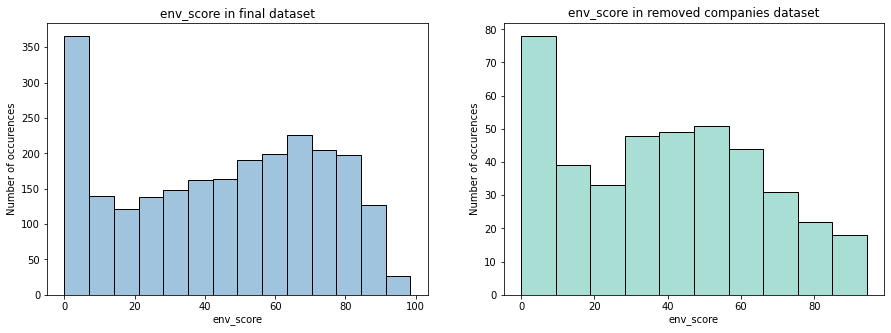

In [112]:
# plot the distribution of the companies dropped because of missing control variables
# versus all of the companies with dependent variables
dist_plot_statistic_tests(removed_env_df, removed_env_comps_df[removed_env_comps_df['ticker'].isin(dependent_but_no_control)], 'env_score')


Mean of the final dataset: 54.81295012180698
Mean of the removed companies dataset: 46.14554371678139
Std of the final dataset: 20.116041910602824
Std of the removed companies dataset: 17.863168274619145
stat=370501.500, p=0.000
Probably different distributions
stat=0.987, p=0.000
Probably not Gaussian
stat=0.987, p=0.000
Probably not Gaussian


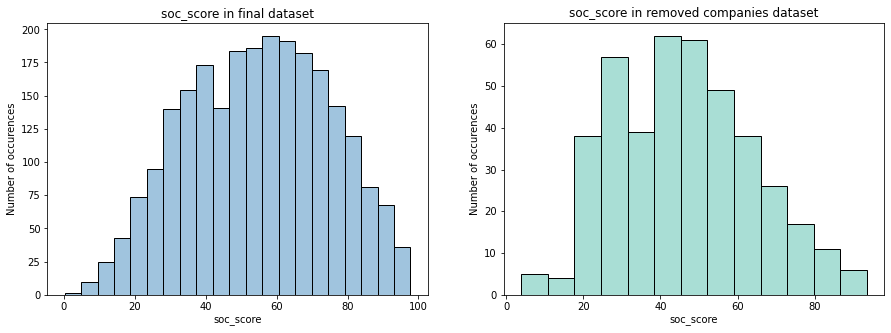

In [113]:
# plot the distribution of the companies dropped because of missing control variables
# versus all of the companies with dependent variables
dist_plot_statistic_tests(removed_soc_df, removed_soc_comps_df[removed_soc_comps_df['ticker'].isin(dependent_but_no_control)], 'soc_score')


In [114]:
# define columns which should be investigated
cols = list(new_env_df.columns[3:])
cols.remove('control_year')
cols.remove('env_score_t_minus_1')
cols.append('soc_score')


Mean of the final dataset: 45.20328658034255
Mean of the removed companies dataset: 43.676700420298815
Std of the final dataset: 28.062814284747798
Std of the removed companies dataset: 31.988400090994713
stat=144243.000, p=0.389
Probably the same distribution
stat=0.944, p=0.000
Probably not Gaussian
stat=0.944, p=0.000
Probably not Gaussian


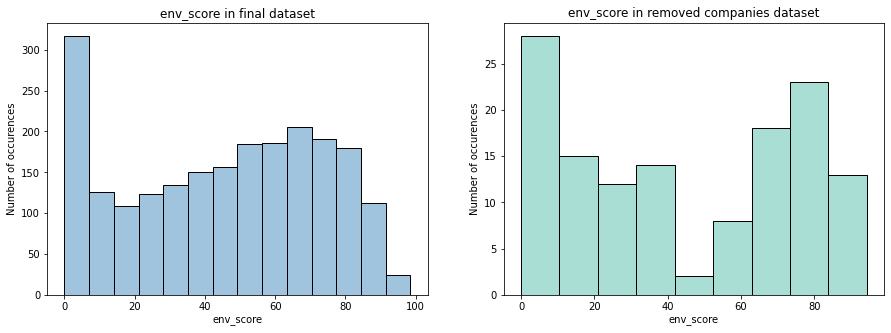

In [115]:
# plot the distributions of the different variables
dist_plot_statistic_tests(new_env_df, dropped_env, cols[0])


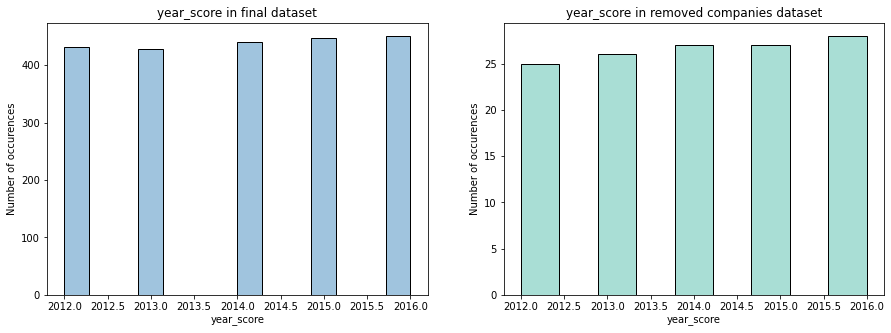

In [116]:
# plot the distributions of the different variables
dist_plot_statistic_tests(new_env_df, dropped_env, cols[1])


Mean of the final dataset: 82.48692412539785
Mean of the removed companies dataset: 76.8739316239316
Std of the final dataset: 10.001122761432283
Std of the removed companies dataset: 21.10513346432589
stat=144315.500, p=0.393
Probably the same distribution
stat=0.869, p=0.000
Probably not Gaussian
stat=0.869, p=0.000
Probably not Gaussian


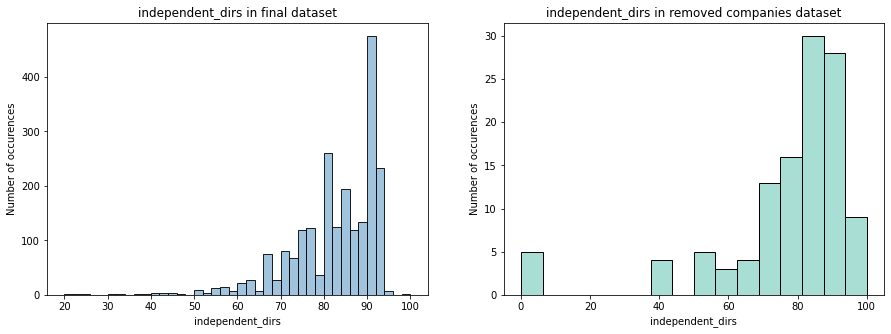

In [117]:
# plot the distributions of the different variables
dist_plot_statistic_tests(new_env_df, dropped_env, cols[2])


Mean of the final dataset: 10.980009086778736
Mean of the removed companies dataset: 9.247863247863247
Std of the final dataset: 2.3705695901482415
Std of the removed companies dataset: 3.3500025293505193
stat=129433.500, p=0.012
Probably different distributions
stat=0.904, p=0.000
Probably not Gaussian
stat=0.904, p=0.000
Probably not Gaussian


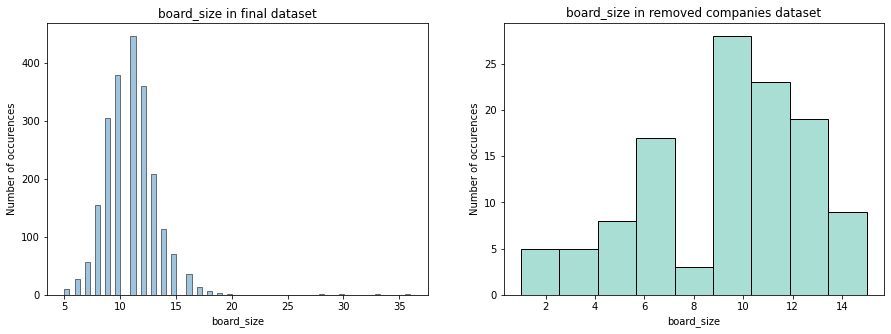

In [118]:
# plot the distributions of the different variables
dist_plot_statistic_tests(new_env_df, dropped_env, cols[3])


Mean of the final dataset: 7.3984643343934655
Mean of the removed companies dataset: 6.773671874999999
Std of the final dataset: 7.183102367217938
Std of the removed companies dataset: 6.084553292837196
stat=141110.000, p=0.243
Probably the same distribution
stat=0.867, p=0.000
Probably not Gaussian
stat=0.867, p=0.000
Probably not Gaussian


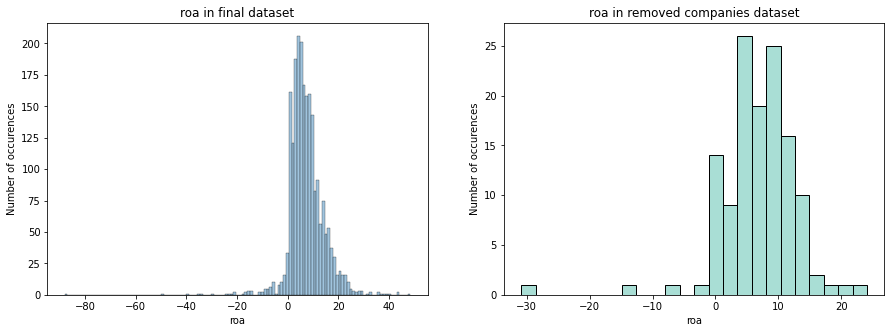

In [119]:
# plot the distributions of the different variables
dist_plot_statistic_tests(new_env_df, dropped_env, cols[4])


Mean of the final dataset: 27.008332576101758
Mean of the removed companies dataset: 23.321875000000016
Std of the final dataset: 18.21046783609204
Std of the removed companies dataset: 14.468389314988684
stat=138847.500, p=0.160
Probably the same distribution
stat=0.957, p=0.000
Probably not Gaussian
stat=0.957, p=0.000
Probably not Gaussian


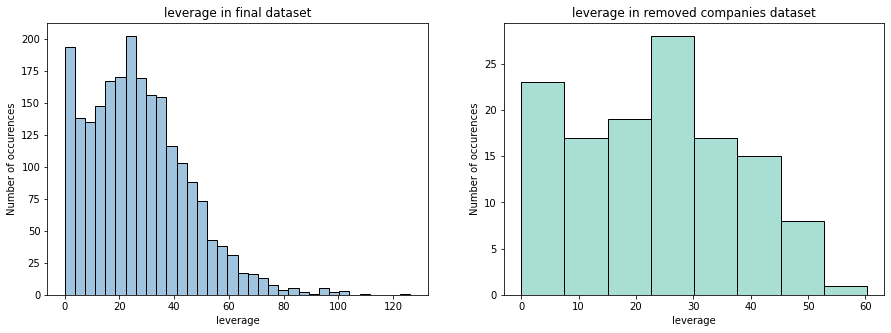

In [120]:
# plot the distributions of the different variables
dist_plot_statistic_tests(new_env_df, dropped_env, cols[5])


Mean of the final dataset: 16.020119636036743
Mean of the removed companies dataset: 16.095232595845562
Std of the final dataset: 1.2106134661114112
Std of the removed companies dataset: 1.097446159278772
stat=129398.000, p=0.012
Probably different distributions
stat=0.983, p=0.000
Probably not Gaussian
stat=0.983, p=0.000
Probably not Gaussian


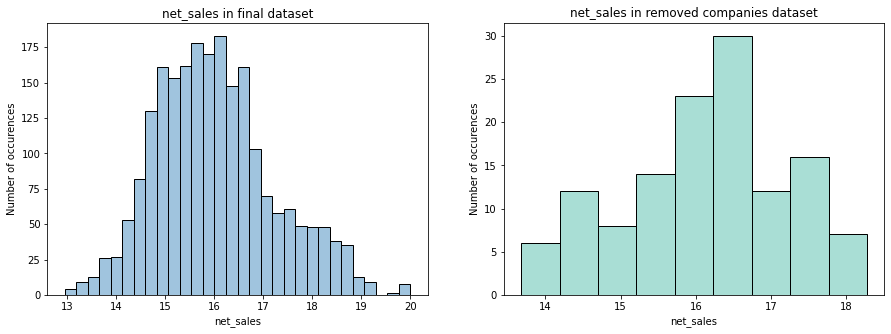

In [121]:
# plot the distributions of the different variables
dist_plot_statistic_tests(new_env_df, dropped_env, cols[6])


Mean of the final dataset: 20.99623353021357
Mean of the removed companies dataset: 19.94515624999999
Std of the final dataset: 13.85304580024266
Std of the removed companies dataset: 11.81949803645068
stat=144898.500, p=0.423
Probably the same distribution
stat=0.931, p=0.000
Probably not Gaussian
stat=0.931, p=0.000
Probably not Gaussian


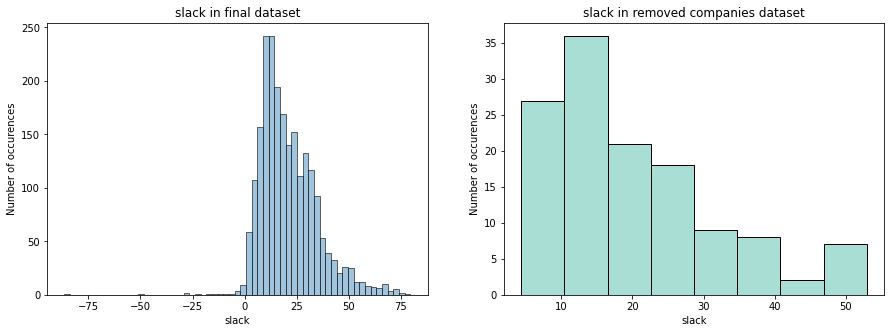

In [122]:
# plot the distributions of the different variables
dist_plot_statistic_tests(new_env_df, dropped_env, cols[7])


Mean of the final dataset: 9.296824170831439
Mean of the removed companies dataset: 7.732330097087378
Std of the final dataset: 3.4948504390521213
Std of the removed companies dataset: 3.1398629931030175
stat=135957.000, p=0.084
Probably the same distribution
stat=0.967, p=0.000
Probably not Gaussian
stat=0.967, p=0.000
Probably not Gaussian


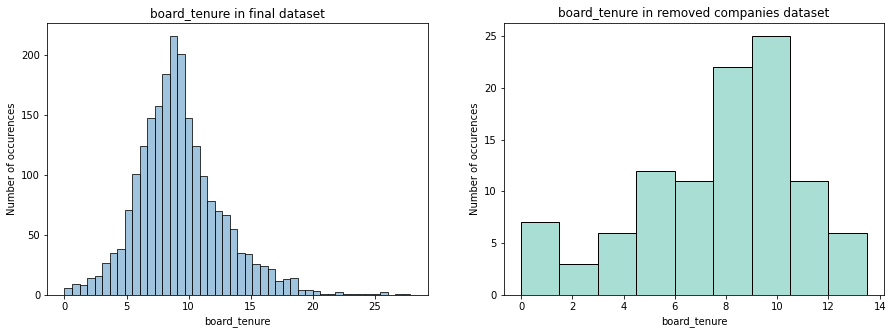

In [123]:
# plot the distributions of the different variables
dist_plot_statistic_tests(new_env_df, dropped_env, cols[8])


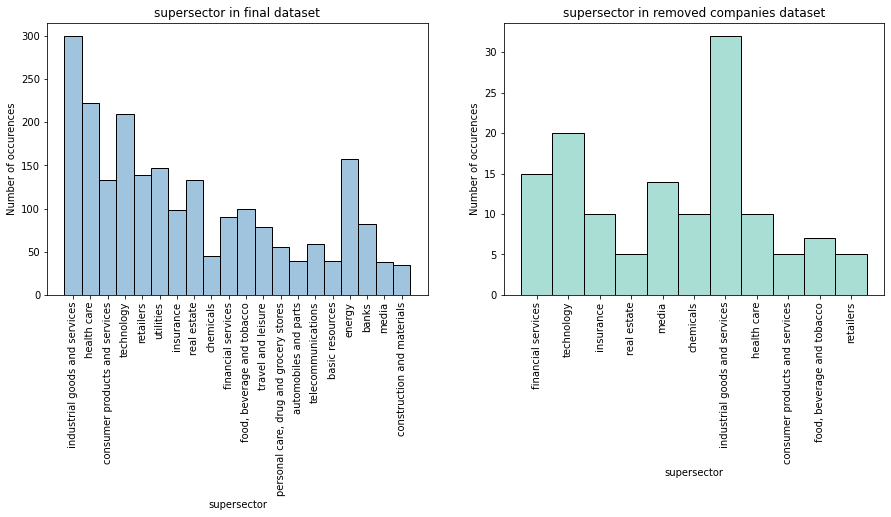

In [124]:
# plot the distributions of the different variables
dist_plot_statistic_tests(new_env_df, dropped_env, cols[9])


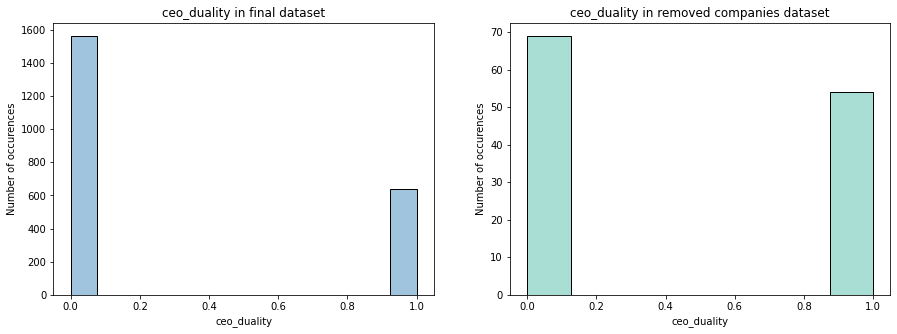

In [125]:
# plot the distributions of the different variables
dist_plot_statistic_tests(new_env_df, dropped_env, cols[12])


Mean of the final dataset: 54.928248157683115
Mean of the removed companies dataset: 57.31132911693468
Std of the final dataset: 20.075673743532967
Std of the removed companies dataset: 20.668890933334023
stat=139103.000, p=0.168
Probably the same distribution
stat=0.987, p=0.000
Probably not Gaussian
stat=0.987, p=0.000
Probably not Gaussian


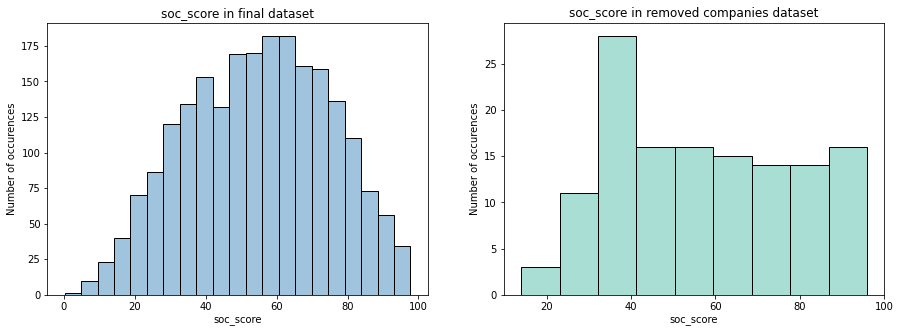

In [126]:
# plot the distributions of the different variables
dist_plot_statistic_tests(new_soc_df, dropped_soc, cols[13])


### Check how many companies are not included for all 5 years

In [127]:
# create dataframe that shows the occurence of each company
complete_years_df = new_env_df.groupby('ticker').count()[['env_score']].copy()
# filter out those companies with less than 5 occurences
complete_years_df[complete_years_df['env_score'] < 5].shape


(51, 1)

# Preprocessing each variable
Necessary preprocessing steps include the following:

* investigate outliers
* investigating multi-collinearity
* overview of industry and year dummies






## Outliers



In [128]:
# plot descriptive statistics
new_env_df.describe()


,env_score,year_score,independent_dirs,board_size,roa,leverage,net_sales,slack,board_tenure,control_year,env_score_t_minus_1,environmental_exp,environmental_comm_exp,ceo_duality
count,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000
mean,45.203287,2014.025897,82.486924,10.980009,7.398464,27.008333,16.020120,20.996234,9.296824,2013.025897,43.369786,0.192289,0.045142,0.290777
std,28.062814,1.415422,10.001123,2.370570,7.183102,18.210468,1.210613,13.853046,3.494850,1.415422,28.359793,0.154383,0.112297,0.454224
min,0.000000,2012.000000,20.000000,5.000000,-88.080000,0.000000,12.949247,-86.510000,0.000000,2011.000000,0.000000,0.000000,0.000000,0.000000
25%,20.938279,2013.000000,77.780000,9.000000,3.570000,13.610000,15.141542,11.160000,7.080000,2012.000000,17.685844,0.083333,0.000000,0.000000
50%,48.460366,2014.000000,84.620000,11.000000,6.550000,25.140000,15.907910,18.230000,8.930000,2013.000000,45.719241,0.166667,0.000000,0.000000
75%,68.664687,2015.000000,90.910000,12.000000,10.690000,38.000000,16.700311,29.000000,11.050000,2014.000000,67.385387,0.285714,0.000000,1.000000
max,98.528805,2016.000000,100.000000,36.000000,48.550000,126.410000,20.001001,79.670000,27.860000,2015.000000,98.528805,0.857143,0.714286,1.000000


In [129]:
# descriptive statistics for the categorical variable
new_env_df['ceo_duality'].value_counts()


0    1561
1     640
Name: ceo_duality, dtype: int64

In [130]:
# plot descriptive statistics
new_soc_df.describe()


,soc_score,year_score,independent_dirs,board_size,roa,leverage,net_sales,slack,board_tenure,control_year,soc_score_t_minus_1,social_exp,social_comm_exp,ceo_duality
count,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000
mean,54.928248,2014.025897,82.486924,10.980009,7.398464,27.008333,16.020120,20.996234,9.296824,2013.025897,53.296270,0.307467,0.071977,0.290777
std,20.075674,1.415422,10.001123,2.370570,7.183102,18.210468,1.210613,13.853046,3.494850,1.415422,20.310688,0.188876,0.152796,0.454224
min,0.264831,2012.000000,20.000000,5.000000,-88.080000,0.000000,12.949247,-86.510000,0.000000,2011.000000,0.264831,0.000000,0.000000,0.000000
25%,39.415004,2013.000000,77.780000,9.000000,3.570000,13.610000,15.141542,11.160000,7.080000,2012.000000,37.436823,0.166667,0.000000,0.000000
50%,55.765205,2014.000000,84.620000,11.000000,6.550000,25.140000,15.907910,18.230000,8.930000,2013.000000,53.578518,0.285714,0.000000,0.000000
75%,70.488818,2015.000000,90.910000,12.000000,10.690000,38.000000,16.700311,29.000000,11.050000,2014.000000,68.585487,0.428571,0.000000,1.000000
max,97.741447,2016.000000,100.000000,36.000000,48.550000,126.410000,20.001001,79.670000,27.860000,2015.000000,96.117318,0.928571,0.833333,1.000000


In [131]:
# adjust list with relevant variables
all_vars = cols.copy()
all_vars.remove('year_score')
all_vars.append('env_score_t_minus_1')
all_vars.append('soc_score_t_minus_1')
all_vars.append('social_exp')
all_vars.append('social_comm_exp')
# make a list with the categorical variables
cat_vars = ['ceo_duality', 'year_score', 'supersector']
# make a list with the numeric variables
num_vars = all_vars.copy()
num_vars.remove('ceo_duality')
num_vars.remove('supersector')
# number of columns minues the irrelevant ones
print('categorical variables:', cat_vars)
print('numeric variables:', num_vars)


categorical variables: ['ceo_duality', 'year_score', 'supersector']
numeric variables: ['env_score', 'independent_dirs', 'board_size', 'roa', 'leverage', 'net_sales', 'slack', 'board_tenure', 'environmental_exp', 'environmental_comm_exp', 'soc_score', 'env_score_t_minus_1', 'soc_score_t_minus_1', 'social_exp', 'social_comm_exp']


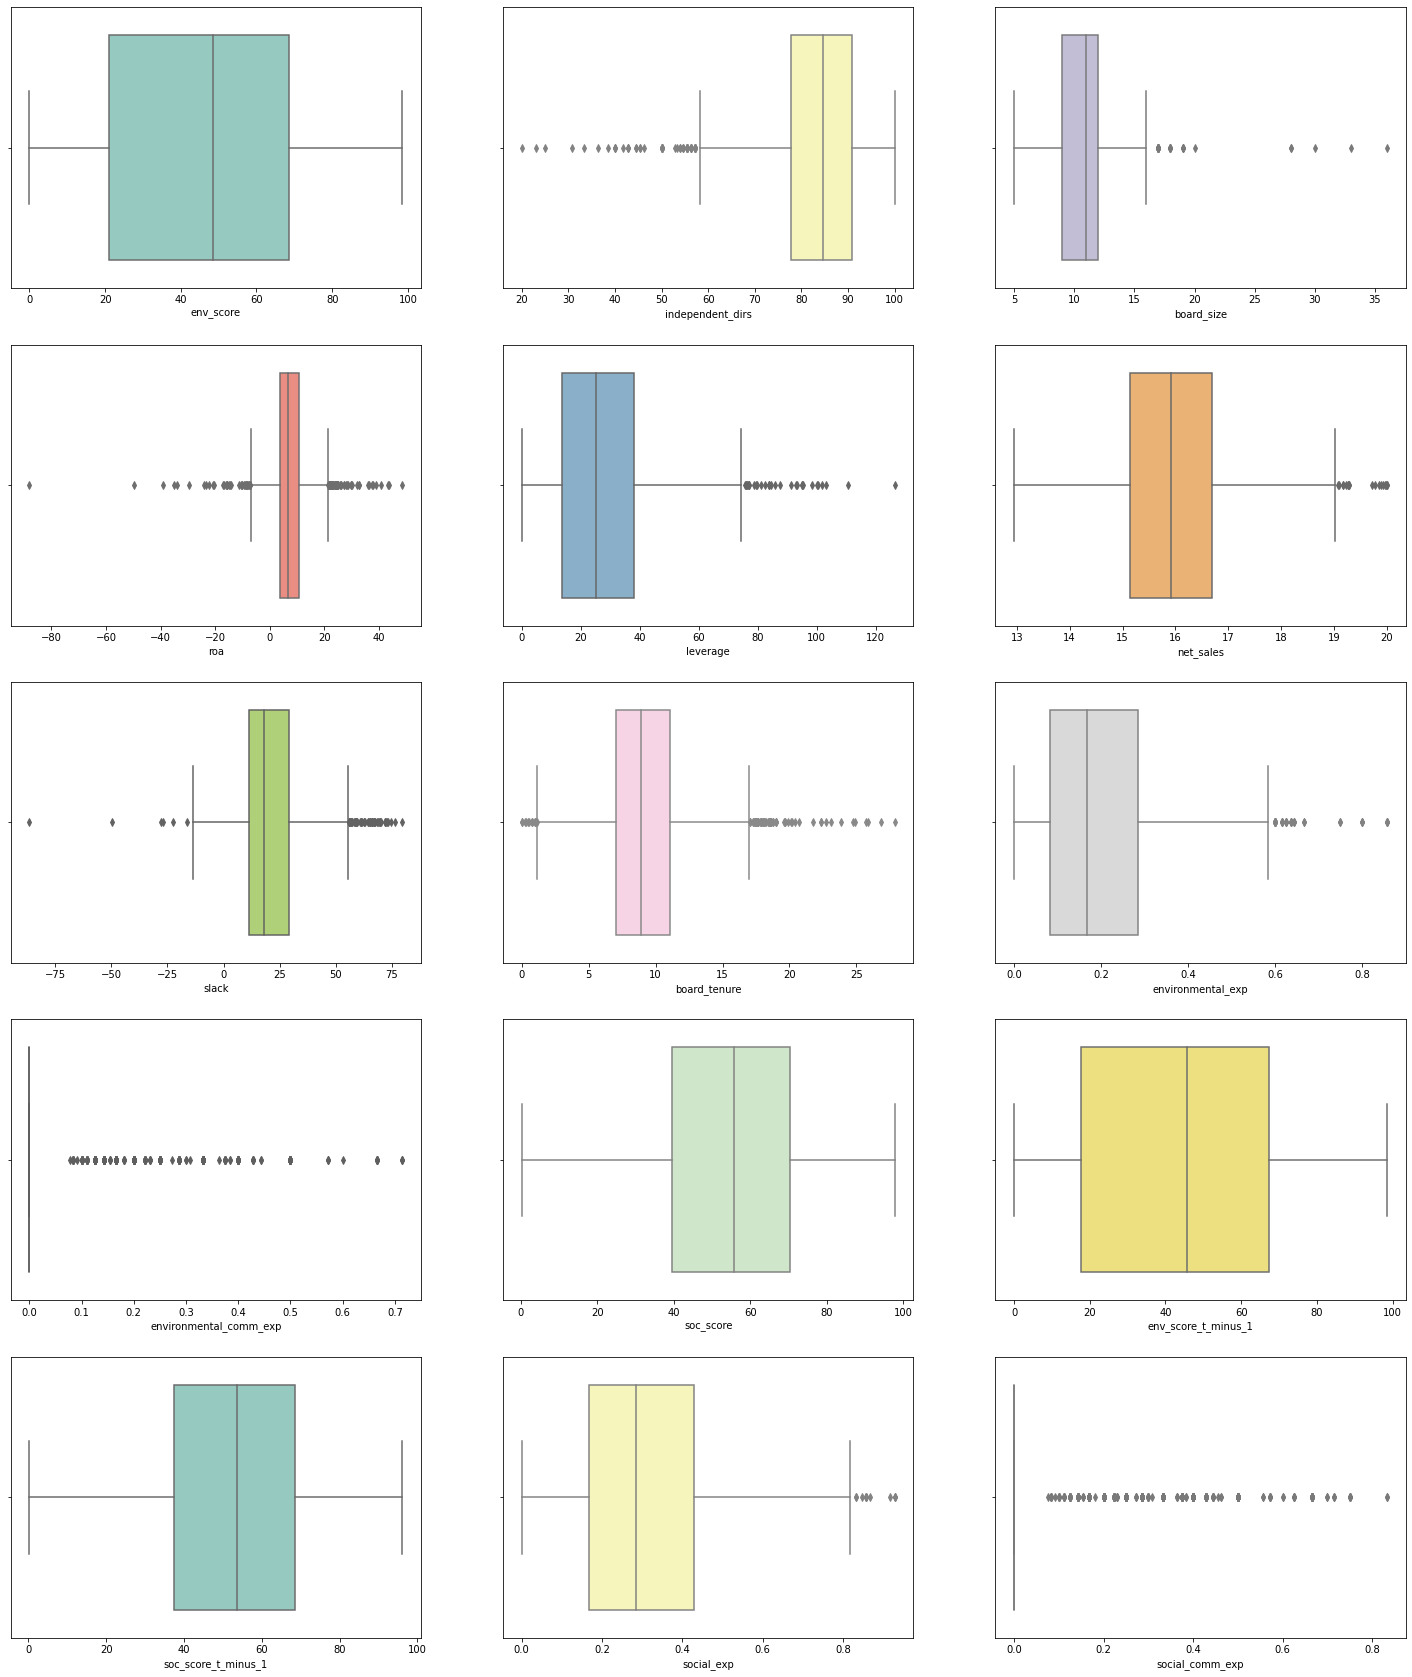

In [132]:
# create boxplot for each variable
fig, axes = plt.subplots(5, 3, figsize=[25, 30])
counter = 0

for j in range(len(axes)):
    for i in range(len(axes[j])):
        if j == 4 and i == 3:
            break
        # define the first subplots
        else:
            if 'soc' in num_vars[counter]:
                axes[j][i] = sb.boxplot(x=new_soc_df[num_vars[counter]], ax=axes[j][i], color=palette[counter])
            else:
                axes[j][i] = sb.boxplot(x=new_env_df[num_vars[counter]], ax=axes[j][i], color=palette[counter])
            counter+=1


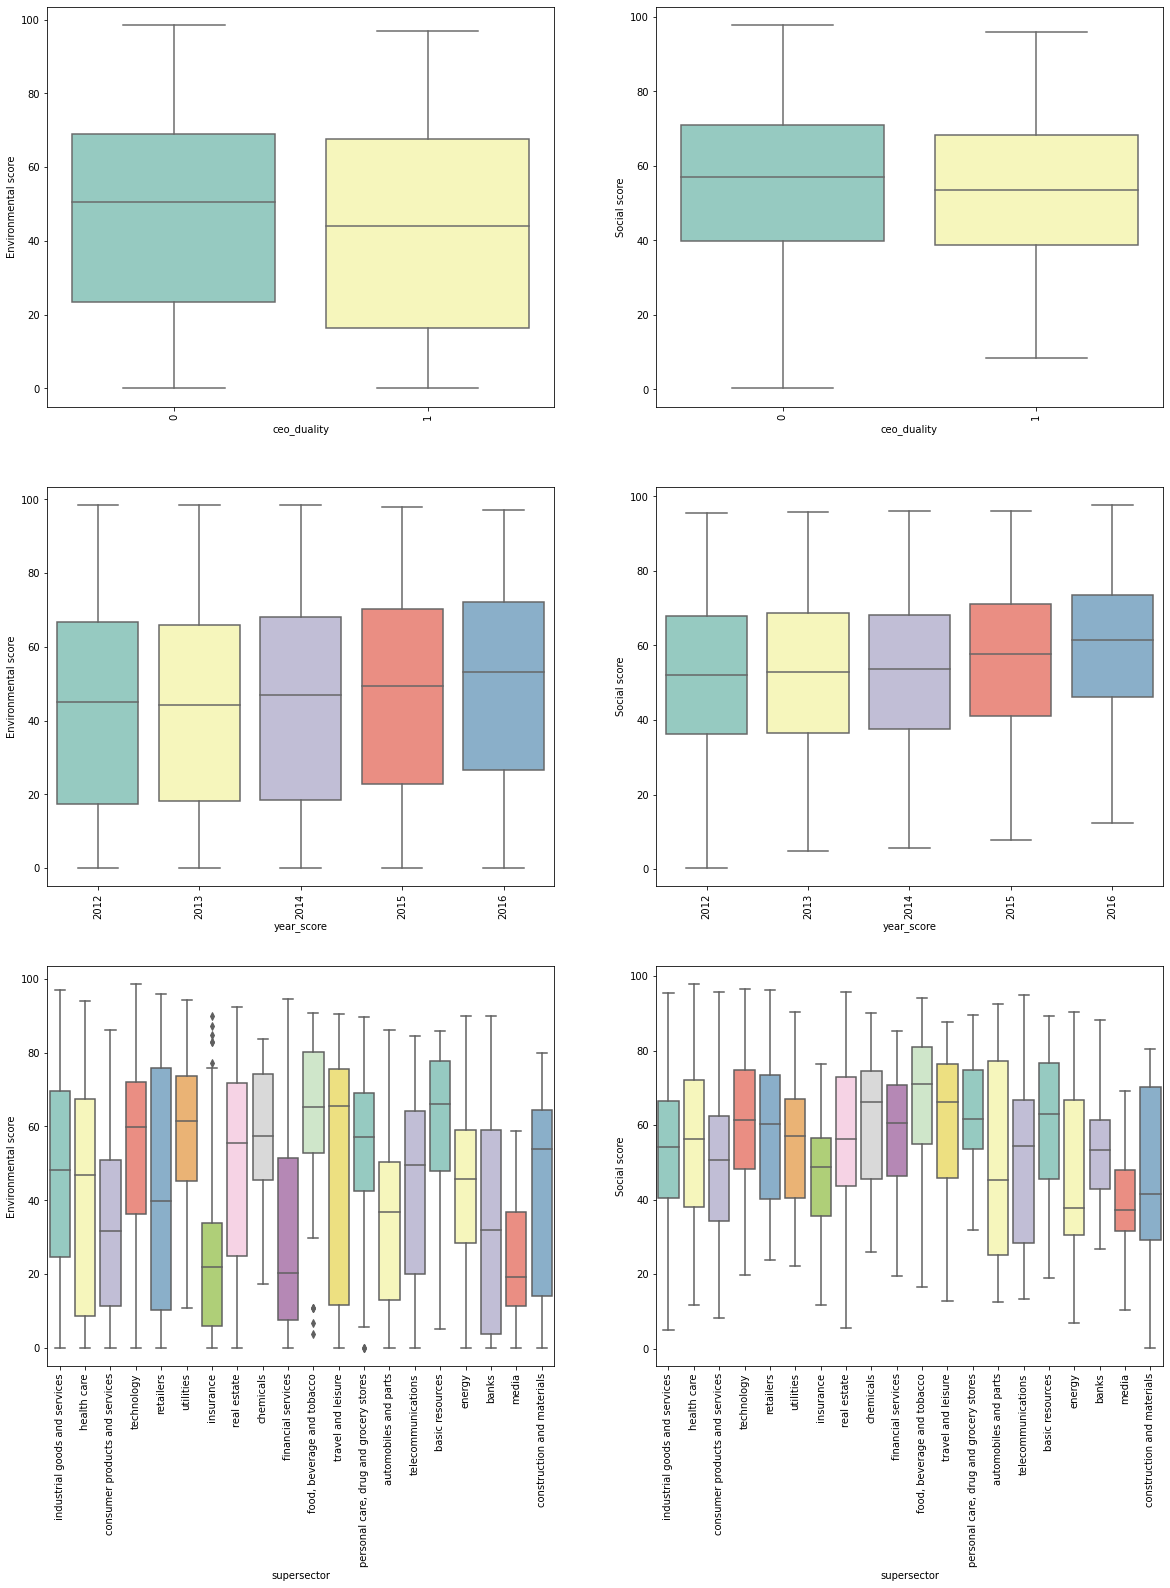

In [133]:
# create boxplot for each variable
fig, axes = plt.subplots(3, 2, figsize=[20, 25])
counter = 0

for j in range(len(axes)):
    for i in range(len(axes[j])):
        if j == 3 and i == 2:
            break
        # define the first subplots
        else:
            if i == 1:
                axes[j][i] = sb.boxplot(data=new_soc_df, x=cat_vars[counter], y='soc_score', ax=axes[j][i], palette=palette)
                labels = list(new_soc_df[cat_vars[counter]].unique())
                axes[j][i].set_xticklabels(labels, rotation=90)
                axes[j][i].set_ylabel('Social score')
            else:
                axes[j][i] = sb.boxplot(data=new_env_df, x=cat_vars[counter], y='env_score', ax=axes[j][i], palette=palette)
                labels = list(new_env_df[cat_vars[counter]].unique())
                axes[j][i].set_xticklabels(labels, rotation=90)
                axes[j][i].set_ylabel('Environmental score')
    counter+=1


The following variables have outliers:


*   independent_dirs
*   board_size
* roa
* leverage
* net_sales
* slack
* board_tenure
* and two supersectors from supersector
* social_exp
* environmental_exp
* social_comm_exp




I added the outlier handling at the very end as a robustness test. My actual sample will be unchanged and this will be just an addition on what could be achieved when the 1st and 99th percentile of each continuous variable would be removed.

In [134]:
def remove_outliers(df, range, env=True):
    '''
    Function to remove outliers
    '''

    # get the 1st and 99th percentiles for each continuous variable
    if env:
        rel_cols = ['env_score', 'independent_dirs', 'board_size', 'roa', 
                    'leverage', 'slack', 'board_tenure', 
                    'env_score_t_minus_1', 'environmental_exp', 
                    'environmental_comm_exp']
    else:
        rel_cols = ['soc_score', 'independent_dirs', 'board_size', 'roa', 
                    'leverage', 'slack', 'board_tenure', 
                    'soc_score_t_minus_1', 'social_exp', 
                    'social_comm_exp']

    # get the percentiles in this dataframe
    quantiles_df = df[rel_cols].quantile(range).copy()

    # save a copy of the original dataframe
    df_copy = df[rel_cols].copy()

    # remove all observations beyond the percentiles
    df_copy = df_copy.apply(lambda x: x[(x>quantiles_df.loc[range[0],x.name]) & 
                                                    (x < quantiles_df.loc[range[1],x.name])], axis=0)  

    # columns to be removed before joining
    remove_cols = list(df_copy.columns)
    df_removed_cols = df.drop(columns=remove_cols).copy()

    # joining the two dataframes
    no_outliers_df = df_copy.join(df_removed_cols, how='left')

    # remove the net_sales variable
    try:
        no_outliers_df.drop(columns=['net_sales'], inplace=True)
    except:
        print('net sales were already removed')
    
    # get dummies for supersector variable
    dummies_df_sector = pd.DataFrame(pd.get_dummies(no_outliers_df['supersector'], drop_first=True))
    new_env_df = no_outliers_df.join(dummies_df_sector)
    # get dummies for year variable
    dummies_df_year = pd.DataFrame(pd.get_dummies(no_outliers_df['year_score'], drop_first=True))
    new_env_df = no_outliers_df.join(dummies_df_year)

    # drop all NaNs
    no_outliers_df.dropna(subset=rel_cols[:-1], inplace=True)
    
    # fill the NaNs in the comm_exp columns
    no_outliers_df[rel_cols[-1]].fillna(0, inplace=True)
    
    return no_outliers_df


In [135]:
# remove the outliers
no_outliers_env_df = remove_outliers(new_env_df, range=[0.01, 0.99], env=True)
no_outliers_soc_df = remove_outliers(new_soc_df, range=[0.01, 0.99], env=False)
print(no_outliers_env_df.shape)
print(no_outliers_soc_df.shape)


(1397, 17)
(1700, 17)


In [136]:
def winsorize_vars(df, env=True):
    '''
    Function to winsorize columns based on certain percentile
    '''

    df_winsor = df.copy()

    # get the 1st and 99th percentiles for each continuous variable
    low = .01
    high = .99

    if env:
        rel_cols = ['env_score', 'independent_dirs', 'board_size', 'roa', 
                    'leverage', 'slack', 'board_tenure', 
                    'env_score_t_minus_1', 'environmental_exp', 
                    'environmental_comm_exp']
    else:
        rel_cols = ['soc_score', 'independent_dirs', 'board_size', 'roa', 
                    'leverage', 'slack', 'board_tenure', 
                    'soc_score_t_minus_1', 'social_exp', 
                    'social_comm_exp']

    for col in rel_cols:
        df_winsor[col] = winsorize(df_winsor[col], limits=[0.01, 0.01])

    # remove the net_sales variable
    df_winsor.drop(columns=['net_sales'], inplace=True)
    
    # get dummies for supersector variable
    dummies_df_sector = pd.DataFrame(pd.get_dummies(df_winsor['supersector'], drop_first=True))
    new_env_df = df_winsor.join(dummies_df_sector)
    # get dummies for year variable
    dummies_df_year = pd.DataFrame(pd.get_dummies(df_winsor['year_score'], drop_first=True))
    new_env_df = df_winsor.join(dummies_df_year)


    return df_winsor


In [137]:
# winsorize all continuous variables
df_winsorized_env = winsorize_vars(new_env_df, env=True)
df_winsorized_soc = winsorize_vars(new_soc_df, env=False)
df_winsorized_env.describe()


,env_score,year_score,independent_dirs,board_size,roa,leverage,slack,board_tenure,control_year,env_score_t_minus_1,environmental_exp,environmental_comm_exp,ceo_duality
count,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000
mean,45.170200,2014.025897,82.585647,10.945479,7.466447,26.868451,21.086792,9.272081,2013.025897,43.336420,0.191336,0.044177,0.290777
std,28.005164,1.415422,9.562675,2.146187,6.120615,17.713957,13.282188,3.354424,1.415422,28.300032,0.151172,0.107559,0.454224
min,0.000000,2012.000000,50.000000,6.000000,-10.270000,0.000000,0.370000,1.810000,2011.000000,0.000000,0.000000,0.000000,0.000000
25%,20.938279,2013.000000,77.780000,9.000000,3.570000,13.610000,11.160000,7.080000,2012.000000,17.685844,0.083333,0.000000,0.000000
50%,48.460366,2014.000000,84.620000,11.000000,6.550000,25.140000,18.230000,8.930000,2013.000000,45.719241,0.166667,0.000000,0.000000
75%,68.664687,2015.000000,90.910000,12.000000,10.690000,38.000000,29.000000,11.050000,2014.000000,67.385387,0.285714,0.000000,1.000000
max,91.714014,2016.000000,93.750000,17.000000,25.740000,79.470000,65.880000,18.960000,2015.000000,91.698245,0.615385,0.500000,1.000000


The variables env_score_t_minus_1 and soc_score_t_minus_1 need to be removed. They were overpowering all other variables because of their very high correlation (see further below) with the dependent variables. I will keep the variables for some of the exploratory analysis in because it is interesting and for future reference, however, for my regression models, I need to remove these variable.

In [138]:
# removing the t_minus_1 variables
no_outliers_env_df.drop(columns=['env_score_t_minus_1'], inplace=True)
no_outliers_soc_df.drop(columns=['soc_score_t_minus_1'], inplace=True)
df_winsorized_env.drop(columns=['env_score_t_minus_1'], inplace=True)
df_winsorized_soc.drop(columns=['soc_score_t_minus_1'], inplace=True)


In [139]:
# save the removed outliers dataframes to a csv file
no_outliers_env_df.to_csv('/content/drive/My Drive/director-csr/no_outliers_env.csv')
no_outliers_soc_df.to_csv('/content/drive/My Drive/director-csr/no_outliers_soc.csv')


In [140]:
# save the winsorized dataframes to a csv file
df_winsorized_env.to_csv('/content/drive/My Drive/director-csr/winsorized_env.csv')
df_winsorized_soc.to_csv('/content/drive/My Drive/director-csr/winsorized_soc.csv')


## Check for multi-collinearity
The investigation of the correlations between the independent and control variables showed that net_sales caused severe multi-collinearity problems. This variable was therefore excluded.

In [141]:
# define dependent variables
dependent_vars = ['soc_score', 'env_score']
# define categorical variables
cat_vars = ['ceo_duality']
# define irrelevant variables
irrelevant_vars = ['ticker', 'comp_name', 'isin', 'control_year', 
                   'supersector', 'year_score', 'env_score_t_minus_1',
                   'soc_score_t_minus_1']
irrelevant_vars.extend(dependent_vars)
# create list of independent variables
independent_vars_env = [x for x in new_env_df.columns if x not in irrelevant_vars]
independent_vars_soc = [x for x in new_soc_df.columns if x not in irrelevant_vars]
# create list of independent numerical variables
independent_vars_num_env = [x for x in independent_vars_env if x not in cat_vars]
independent_vars_num_soc = [x for x in independent_vars_soc if x not in cat_vars]
independent_vars_num_env


['independent_dirs',
 'board_size',
 'roa',
 'leverage',
 'net_sales',
 'slack',
 'board_tenure',
 'environmental_exp',
 'environmental_comm_exp']

In [142]:
# reset indices to prepare for standard scaling
new_env_df.reset_index(drop=True, inplace=True)
new_soc_df.reset_index(drop=True, inplace=True)


In [143]:
# remove the net_sales variable
independent_vars_num_env.remove('net_sales')
independent_vars_num_soc.remove('net_sales')
independent_vars_env.remove('net_sales')
independent_vars_soc.remove('net_sales')
new_env_df.drop(columns=['net_sales'], inplace=True)
new_soc_df.drop(columns=['net_sales'], inplace=True)


In [144]:
# get dummies for supersector variable
dummies_df_sector = pd.DataFrame(pd.get_dummies(new_env_df['supersector'], drop_first=True))
new_env_df = new_env_df.join(dummies_df_sector)

dummies_df_sector = pd.DataFrame(pd.get_dummies(new_soc_df['supersector'], drop_first=True))
new_soc_df = new_soc_df.join(dummies_df_sector)


In [145]:
# get dummies for year_score variable
dummies_df_year = pd.DataFrame(pd.get_dummies(new_env_df['year_score'], drop_first=True))
new_env_df = new_env_df.join(dummies_df_year)

dummies_df_year = pd.DataFrame(pd.get_dummies(new_soc_df['year_score'], drop_first=True))
new_soc_df = new_soc_df.join(dummies_df_year)


In [146]:
# combine all dummy variables
dummies_sector_list = list(dummies_df_sector.columns)
dummies_sector_list.extend(list(dummies_df_year.columns))
dummies_sector_list


['banks',
 'basic resources',
 'chemicals',
 'construction and materials',
 'consumer products and services',
 'energy',
 'financial services',
 'food, beverage and tobacco',
 'health care',
 'industrial goods and services',
 'insurance',
 'media',
 'personal care, drug and grocery stores',
 'real estate',
 'retailers',
 'technology',
 'telecommunications',
 'travel and leisure',
 'utilities',
 2013,
 2014,
 2015,
 2016]

In [147]:
# add the supersector and year categories to the cat_vars variables
cat_vars.extend(dummies_df_sector.columns)
# add the supersector categories to the independent variables list
independent_vars_env.extend(dummies_df_sector.columns)
independent_vars_soc.extend(dummies_df_sector.columns)


In [148]:
def p_levels(df, vars):
    '''
    Function to calculate the p-levels of correlations
    Args: df = dataframe
          vars = list
    Returns: var_p_matrix = dataframe
    '''

    # matrix with p-values
    var_p_matrix = pd.DataFrame(data=None, columns=vars)

    for var_col in vars:
        for var_row in vars:
            r, p = pearsonr(df[var_col], df[var_row])
            if p > 0.1:
                var_p_matrix.at[var_row, var_col] = 'not significant'
            elif p <= 0.1 and p > 0.05:
                var_p_matrix.at[var_row, var_col] = '★'
            elif p <= 0.05 and p > 0.01:
                var_p_matrix.at[var_row, var_col] = '★★'
            elif p <= 0.01 and p >= 0.00:
                var_p_matrix.at[var_row, var_col] = '★★★'

    return var_p_matrix


In [149]:
# color palette for heatmaps
#sns.color_palette("vlag", as_cmap=True)
heatmap_palette = sb.color_palette('coolwarm', as_cmap=True)


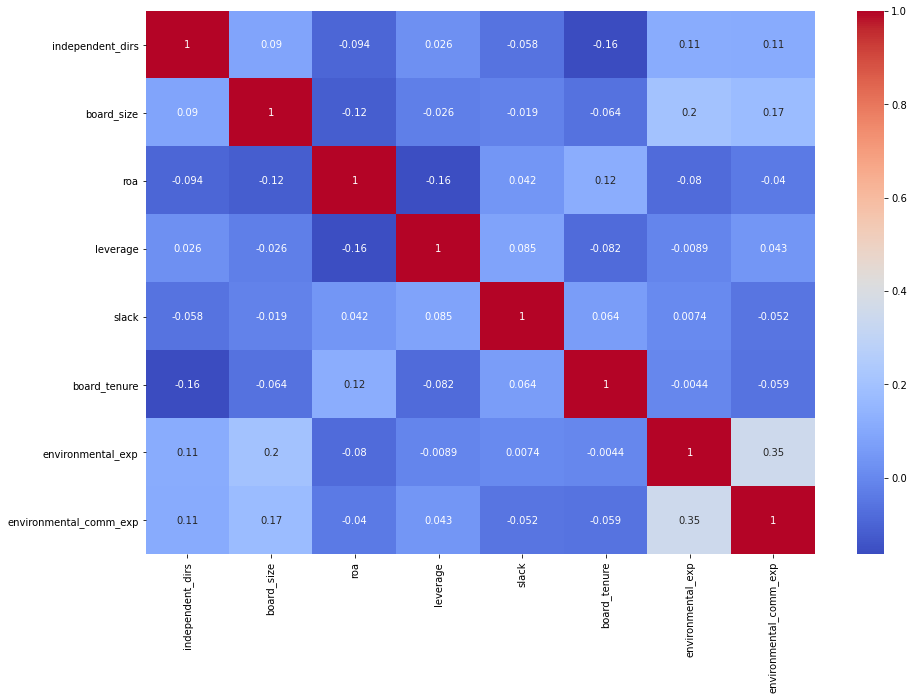

In [150]:
# correlation matrix and heatmap
env_corr_matrix = new_env_df[independent_vars_num_env].corr()

plt.figure(figsize=[15, 10])
sb.heatmap(env_corr_matrix, annot=True, cmap=heatmap_palette)
plt.show()


In [151]:
# p-levels for environmental
p_levels(new_env_df, independent_vars_num_env)


,independent_dirs,board_size,roa,leverage,slack,board_tenure,environmental_exp,environmental_comm_exp
independent_dirs,★★★,★★★,★★★,not significant,★★★,★★★,★★★,★★★
board_size,★★★,★★★,★★★,not significant,not significant,★★★,★★★,★★★
roa,★★★,★★★,★★★,★★★,★,★★★,★★★,★
leverage,not significant,not significant,★★★,★★★,★★★,★★★,not significant,★★
slack,★★★,not significant,★,★★★,★★★,★★★,not significant,★★
board_tenure,★★★,★★★,★★★,★★★,★★★,★★★,not significant,★★★
environmental_exp,★★★,★★★,★★★,not significant,not significant,not significant,★★★,★★★
environmental_comm_exp,★★★,★★★,★,★★,★★,★★★,★★★,★★★


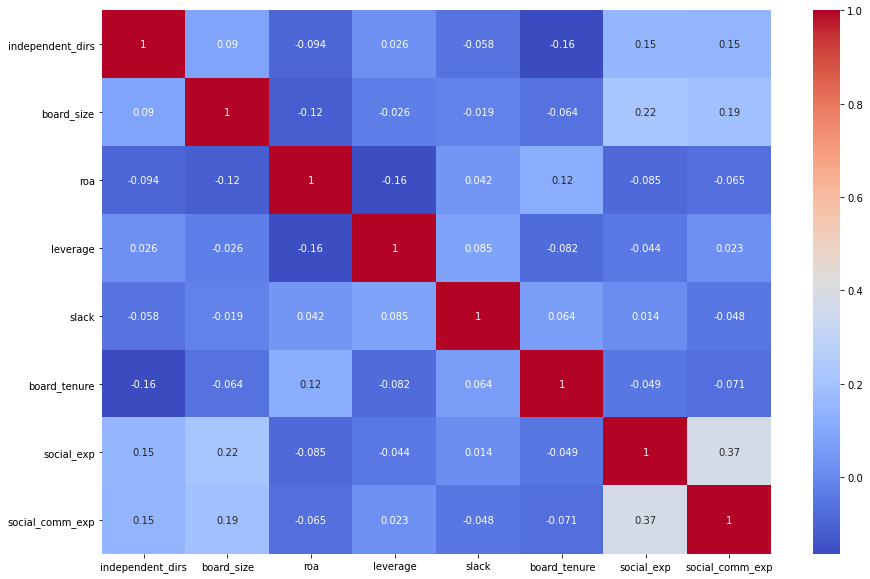

In [152]:
# correlation matrix and heatmap
soc_corr_matrix = new_soc_df[independent_vars_num_soc].corr()

plt.figure(figsize=[15, 10])
sb.heatmap(soc_corr_matrix, annot=True, cmap=heatmap_palette)
plt.show()


In [153]:
# p-levels for social
p_levels(new_soc_df, independent_vars_num_soc)


,independent_dirs,board_size,roa,leverage,slack,board_tenure,social_exp,social_comm_exp
independent_dirs,★★★,★★★,★★★,not significant,★★★,★★★,★★★,★★★
board_size,★★★,★★★,★★★,not significant,not significant,★★★,★★★,★★★
roa,★★★,★★★,★★★,★★★,★,★★★,★★★,★★★
leverage,not significant,not significant,★★★,★★★,★★★,★★★,★★,not significant
slack,★★★,not significant,★,★★★,★★★,★★★,not significant,★★
board_tenure,★★★,★★★,★★★,★★★,★★★,★★★,★★,★★★
social_exp,★★★,★★★,★★★,★★,not significant,★★,★★★,★★★
social_comm_exp,★★★,★★★,★★★,not significant,★★,★★★,★★★,★★★


In [154]:
# create correlation matrix for all dependent and independent variables (social and environmental)
env_df = new_env_df[['env_score', 'environmental_exp', 'environmental_comm_exp', 'env_score_t_minus_1']].copy()
soc_df = new_soc_df[['soc_score', 'social_exp', 'social_comm_exp', 'soc_score_t_minus_1']].copy()

# combine the social and environmental values
env_soc_corr = env_df.join(soc_df)
env_soc_corr.head()


,env_score,environmental_exp,environmental_comm_exp,env_score_t_minus_1,soc_score,social_exp,social_comm_exp,soc_score_t_minus_1
0,83.891263,0.400000,0.0,84.273026,89.772790,0.500000,0.0,87.935154
1,52.133087,0.461538,0.0,54.215270,88.945777,0.692308,0.0,91.631630
2,0.000000,0.090909,0.0,0.000000,8.333083,0.272727,0.0,16.358999
3,80.082004,0.111111,0.0,81.583694,66.735633,0.333333,0.0,65.855829
4,7.411255,0.181818,0.0,16.345811,33.801158,0.363636,0.0,33.343925


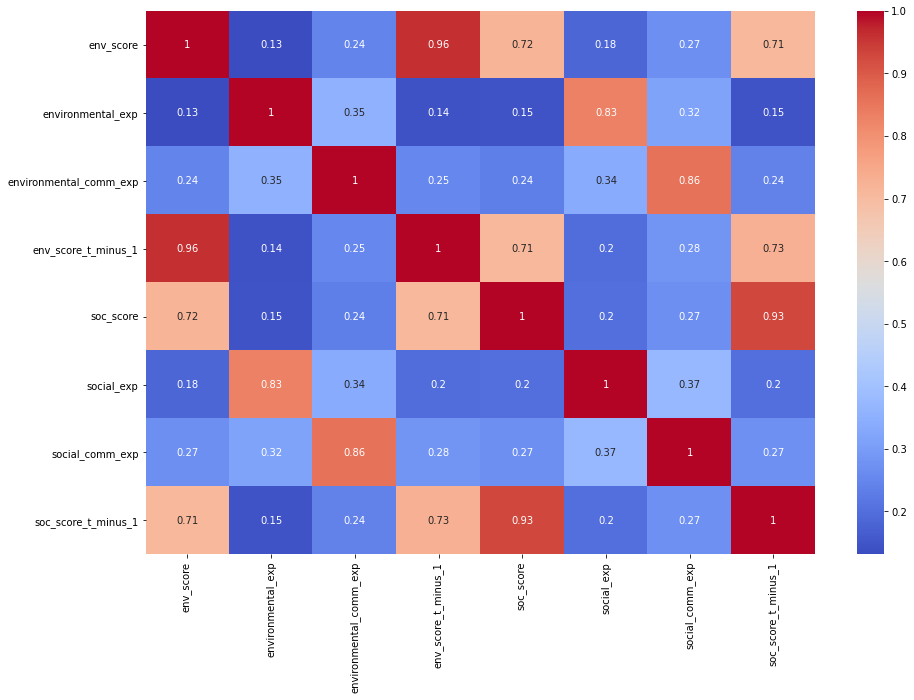

In [155]:
# correlation matrix and heatmap
env_soc_corr_matrix = env_soc_corr.corr()

plt.figure(figsize=[15, 10])
sb.heatmap(env_soc_corr_matrix, annot=True, cmap=heatmap_palette)
plt.show()


In [156]:
# p-levels for social and environmental
env_vars = ['env_score', 'environmental_exp', 'environmental_comm_exp', 'env_score_t_minus_1']
soc_vars = ['soc_score', 'social_exp', 'social_comm_exp', 'soc_score_t_minus_1']
env_vars.extend(soc_vars)
p_levels(env_soc_corr, env_vars)


,env_score,environmental_exp,environmental_comm_exp,env_score_t_minus_1,soc_score,social_exp,social_comm_exp,soc_score_t_minus_1
env_score,★★★,★★★,★★★,★★★,★★★,★★★,★★★,★★★
environmental_exp,★★★,★★★,★★★,★★★,★★★,★★★,★★★,★★★
environmental_comm_exp,★★★,★★★,★★★,★★★,★★★,★★★,★★★,★★★
env_score_t_minus_1,★★★,★★★,★★★,★★★,★★★,★★★,★★★,★★★
soc_score,★★★,★★★,★★★,★★★,★★★,★★★,★★★,★★★
social_exp,★★★,★★★,★★★,★★★,★★★,★★★,★★★,★★★
social_comm_exp,★★★,★★★,★★★,★★★,★★★,★★★,★★★,★★★
soc_score_t_minus_1,★★★,★★★,★★★,★★★,★★★,★★★,★★★,★★★


## Overview of industries and years

In [157]:
# create dataframe with industries, years and tickers
industries_df = pd.DataFrame(new_env_df.groupby(['year_score', 'supersector']).count()['ticker']).reset_index()
industries_df.head()


,year_score,supersector,ticker
0,2012,automobiles and parts,7
1,2012,banks,16
2,2012,basic resources,8
3,2012,chemicals,9
4,2012,construction and materials,7


In [158]:
# pivot the dataframe to have the supersector as an index and the years as columns
year_industry_df = pd.pivot(industries_df, index=['supersector'], columns=['year_score'], values=['ticker'])
year_industry_df.loc['Total']= year_industry_df.sum()
year_industry_df


ticker                    
year_score                               2012 2013 2014 2015 2016
supersector                                                      
automobiles and parts                       7    8    8    8    8
banks                                      16   16   16   17   17
basic resources                             8    7    8    8    8
chemicals                                   9    9    9    9    9
construction and materials                  7    7    7    7    7
consumer products and services             25   25   28   28   27
energy                                     31   30   32   32   32
financial services                         17   17   16   20   20
food, beverage and tobacco                 20   20   20   20   20
health care                                43   43   44   46   47
industrial goods and services              58   57   61   62   62
insurance                                  20   20   19   19   20
media                                       7    7    8    8    8
personal care, drug and grocery stores     11   11   11   11   11
real estate                                26   26   26   27   28
retailers                                  28   28   28   28   27
technology                                 41   41   42   42   44
telecommunications                         12   12   12   12   11
travel and leisure                         16   16   16   15   16
utilities                                  30   29   30   29   29
Total                                     432  429  441  448  451

# Save the cleaned data
As mentioned earlier, the two t_minus_1 variables need to be removed. My r-sqaured value was in the 90s because these variables were overpowering all other variables because of the high correlation.

In [159]:
# removing the t_minus_1 variables
new_env_df.drop(columns=['env_score_t_minus_1'], inplace=True)
new_soc_df.drop(columns=['soc_score_t_minus_1'], inplace=True)


In [160]:
# write the dataframes to csv files
new_env_df.to_csv('/content/drive/My Drive/director-csr/env_score_dataset.csv')
new_soc_df.to_csv('/content/drive/My Drive/director-csr/soc_score_dataset.csv')


# Exploring selected variables

## Visually

In [161]:
def compare_scores(df, comp_list, env=True, industry=True):
    '''
    Function to create boxplots comparing either industries or years
    Args: df = dataframe
          comp_list = list; contains either two years or names of two industries
          env = boolean; True marks environmental data and False marks social data
          industry = boolean; True marks industry and False marks year
    Returns: None
    '''

    if industry:
        comp_col = 'supersector'
        x_col = 'year_score'
        xlabel = 'Years'
        rotation = 0
    else:
        comp_col = 'year_score'
        x_col = 'supersector'
        xlabel = 'Industries'
        rotation = 90

    if env:
        score = 'env_score'
        ylabel = 'Environmental score'
    else:
        score = 'soc_score'
        ylabel = 'Social score'

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    # define the first subplots
    comp_df = df[df[comp_col] == comp_list[0]].copy()
    sb.boxplot(data=comp_df, x=x_col, y=score, palette=palette, ax=axes[0])
    axes[0].set(xlabel=xlabel, ylabel=ylabel, title=ylabel+' for '+str(comp_list[0]))
    labels = list(df[x_col].unique())
    if not industry:
        labels = [x.title() for x in labels]
    axes[0].set_xticklabels(labels, rotation=rotation)
    axes[0].set(ylim=(-5, 105))

    # define the second subplot
    comp_df = df[df[comp_col] == comp_list[1]].copy()
    sb.boxplot(data=comp_df, x=x_col, y=score, palette=palette, ax=axes[1])
    axes[1].set(xlabel=xlabel, ylabel=ylabel, title=ylabel+' for '+str(comp_list[1]))
    labels = list(df[x_col].unique())
    if not industry:
        labels = [x.title() for x in labels]
    axes[1].set_xticklabels(labels, rotation=rotation)
    axes[1].set(ylim=(-5, 105))


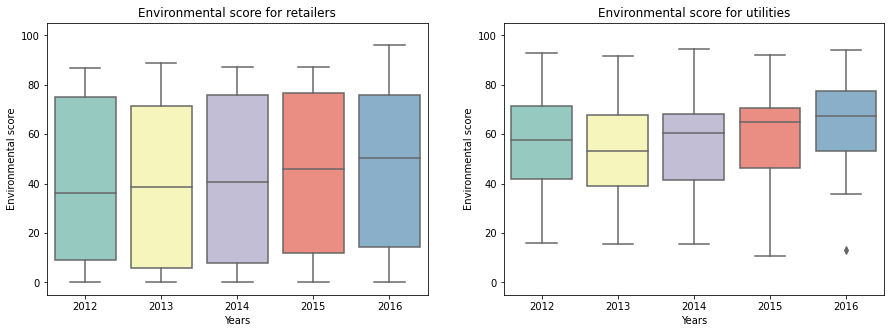

In [162]:
# boxplots for two industries and their environmental score for all years
compare_scores(new_env_df, ['retailers', 'utilities'], env=True, industry=True)


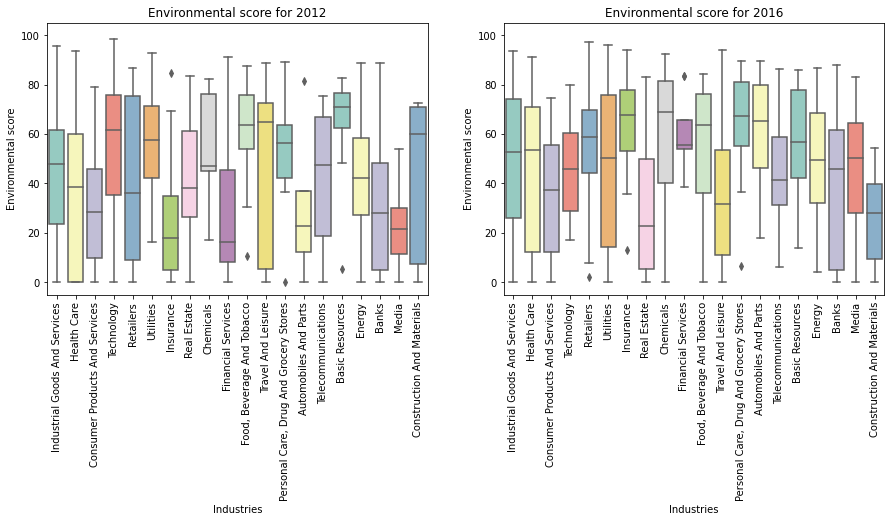

In [163]:
# boxplots for all industries and their environmental score for 2012 and 2016
compare_scores(new_env_df, [2012, 2016], env=True, industry=False)


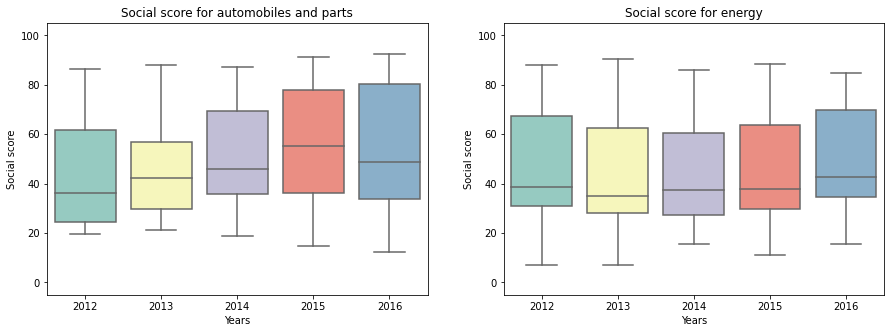

In [164]:
# boxplots for two industries and their social score for all years
compare_scores(new_soc_df, ['automobiles and parts', 'energy'], env=False, industry=True)


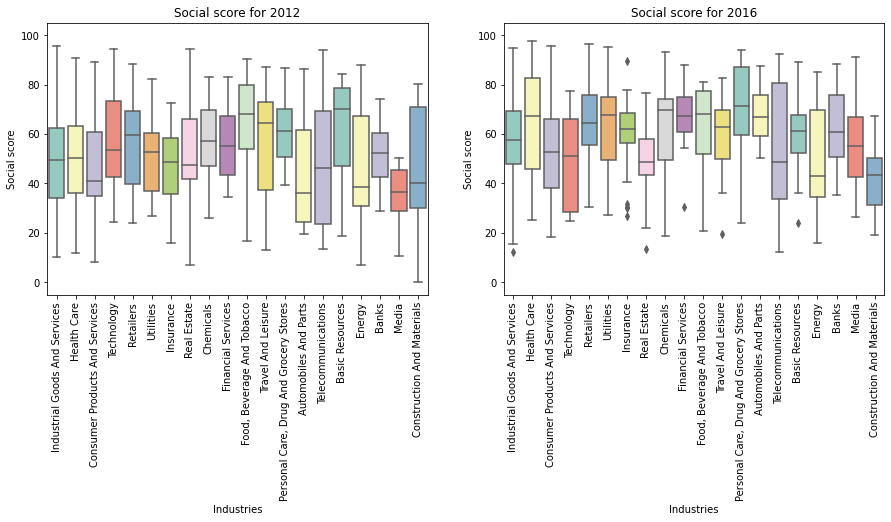

In [165]:
# boxplots for all industries and their social score for 2012 and 2016
compare_scores(new_soc_df, [2012, 2016], env=False, industry=False)


In [166]:
def create_subplots(df1, df2, var_x, var_y, xlabel, ylabel1, 
                    ylabel2, title1, title2, axis_lim):
    '''
    Function to create subplots
    Args: df1 = dataframe
          df2 = dataframe
          var_x = str
          var_y = list
          xlabel = str
          ylabel1 = str
          ylabel2 = str
          title1 = str
          title2 = str
          axis_lim = tuple
    Returns: None
    '''

    # plot all companies for all years without industry distinction
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    # define the first subplots
    axes[0] = sb.boxplot(data=df1, x=var_x, y=var_y[0], palette=palette, ax=axes[0])
    axes[0].set(xlabel=xlabel, ylabel=ylabel1, title=title1)
    axes[0].set(ylim=axis_lim)

    # define the first subplots
    axes[1] = sb.boxplot(data=df2, x=var_x, y=var_y[1], palette=palette, ax=axes[1])
    axes[1].set(xlabel=xlabel, ylabel=ylabel2, title=title2)
    axes[1].set(ylim=axis_lim);



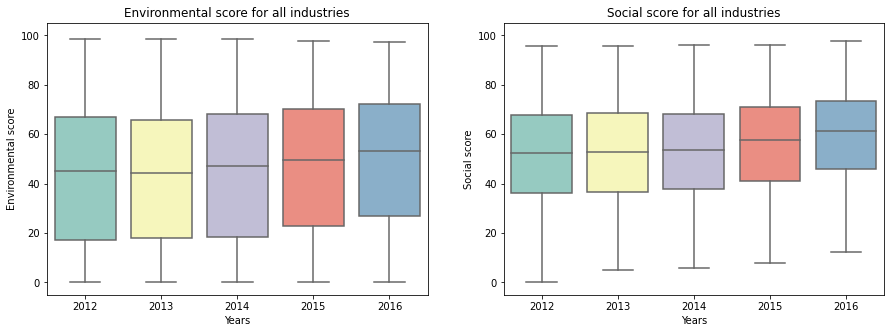

In [167]:
# create boxplots for all industries
create_subplots(new_env_df, new_soc_df, 'year_score', ['env_score', 'soc_score'],
                'Years', 'Environmental score', 'Social score',
                'Environmental score for all industries',
                'Social score for all industries', axis_lim=(-5, 105))


I want to compare what social scores the top 10% of environmental score holders have and the environmental scores that the top 10% of the social score holders have.

In [168]:
def get_top_perc(df_10, df_all, var, range):
    '''
    Function to get the top 10 % of a variable
    Args: df_10 = dataframe
          df_all = dataframe
          var = str
          range = list
    '''

    # get the percentiles in this dataframe
    quantiles_df = df_10[[var]].quantile(range).copy()

    # save a copy of the original dataframe
    df_copy = df_10[[var]].copy()

    # remove all observations beyond the percentiles
    df_copy = df_copy.apply(lambda x: x[(x>quantiles_df.loc[range[0],x.name]) & 
                                                    (x < quantiles_df.loc[range[1],x.name])], axis=0)  

    top_10 = df_copy.join(df_all, how='left')
    
    return top_10


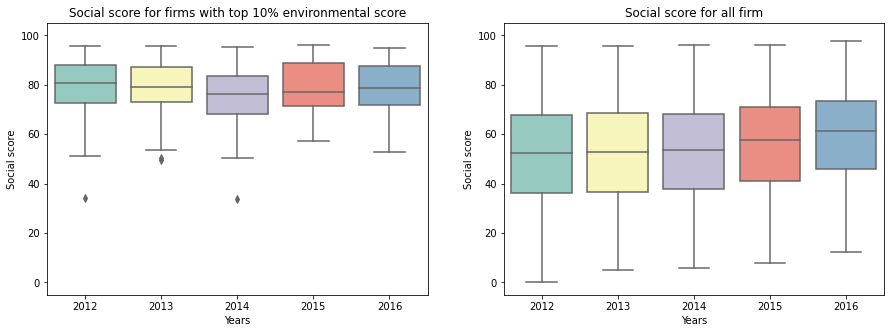

In [169]:
# get the top 10 percent of companies with environmental score
top_10_env = get_top_perc(new_env_df, new_soc_df, 'env_score', [0.90, 1.0])
# create a boxplot
create_subplots(top_10_env, new_soc_df, 'year_score', ['soc_score', 'soc_score'],
                'Years', 'Social score', 'Social score',
                'Social score for firms with top 10% environmental score',
                'Social score for all firm', axis_lim=(-5, 105))


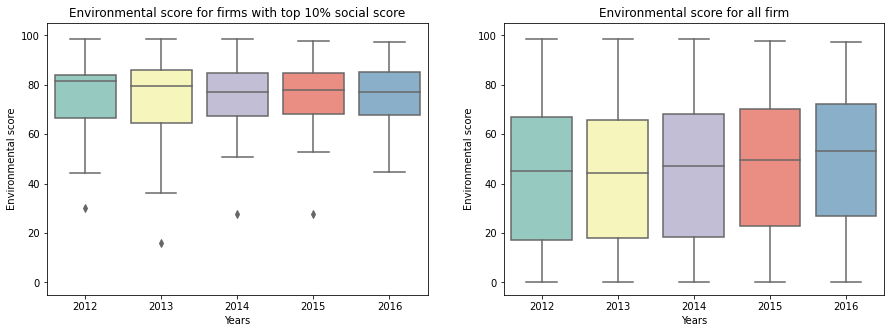

In [170]:
# get the top 10 percent of companies with environmental score
top_10_soc = get_top_perc(new_soc_df, new_env_df, 'soc_score', [0.90, 1.0])
# create a boxplot
create_subplots(top_10_soc, new_env_df, 'year_score', ['env_score', 'env_score'],
                'Years', 'Environmental score', 'Environmental score',
                'Environmental score for firms with top 10% social score',
                'Environmental score for all firm', axis_lim=(-5, 105))


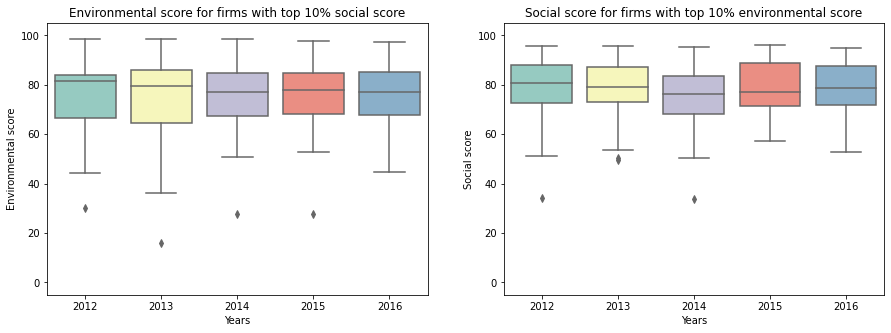

In [171]:
# create a boxplot
create_subplots(top_10_soc, top_10_env, 'year_score', ['env_score', 'soc_score'],
                'Years', 'Environmental score', 'Social score',
                'Environmental score for firms with top 10% social score',
                'Social score for firms with top 10% environmental score', axis_lim=(-5, 105))


I will create boxplots which show the quantiles of the experience scores.

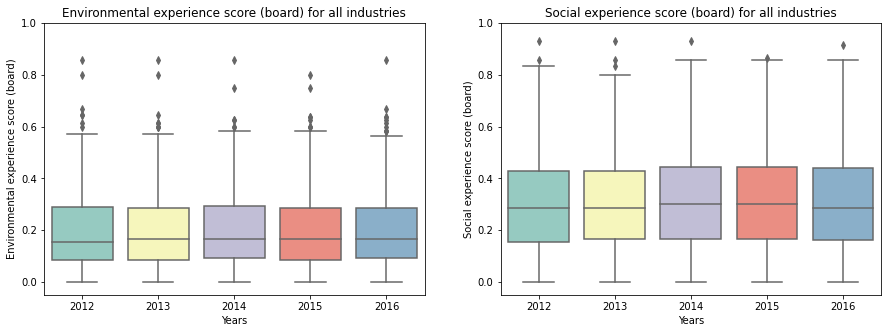

In [172]:
# create boxplots for all industries
create_subplots(new_env_df, new_soc_df, 'year_score', ['environmental_exp', 'social_exp'],
                'Years', 'Environmental experience score (board)', 'Social experience score (board)',
                'Environmental experience score (board) for all industries',
                'Social experience score (board) for all industries', axis_lim=(-0.05, 1))


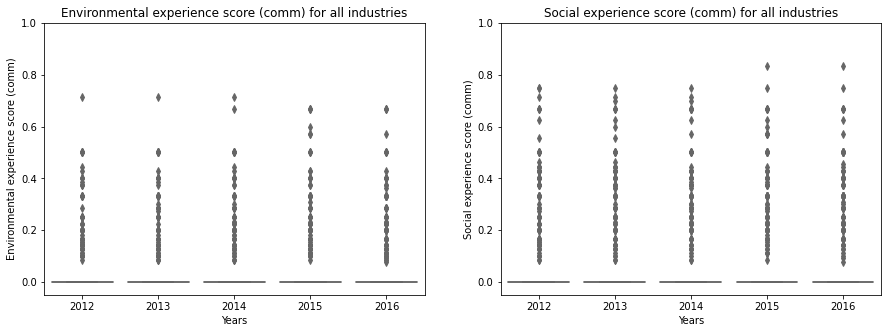

In [173]:
# create boxplots for all industries
create_subplots(new_env_df, new_soc_df, 'year_score', ['environmental_comm_exp', 'social_comm_exp'],
                'Years', 'Environmental experience score (comm)', 'Social experience score (comm)',
                'Environmental experience score (comm) for all industries',
                'Social experience score (comm) for all industries', axis_lim=(-0.05, 1.0))


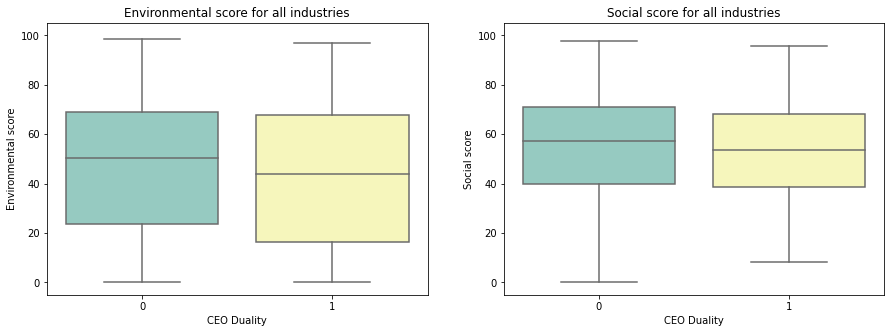

In [174]:
# create boxplots for all industries
create_subplots(new_env_df, new_soc_df, 'ceo_duality', ['env_score', 'soc_score'],
                'CEO Duality', 'Environmental score', 'Social score',
                'Environmental score for all industries',
                'Social score for all industries', axis_lim=(-5, 105))


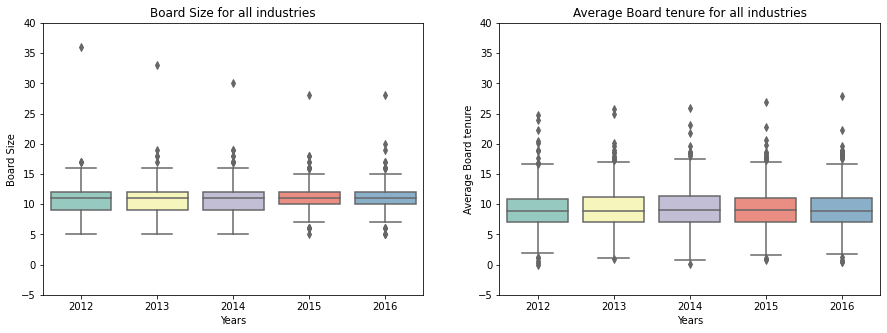

In [175]:
# create boxplots for all industries
create_subplots(new_env_df, new_soc_df, 'year_score', ['board_size', 'board_tenure'],
                'Years', 'Board Size', 'Average Board tenure',
                'Board Size for all industries',
                'Average Board tenure for all industries', axis_lim=(-5, 40))


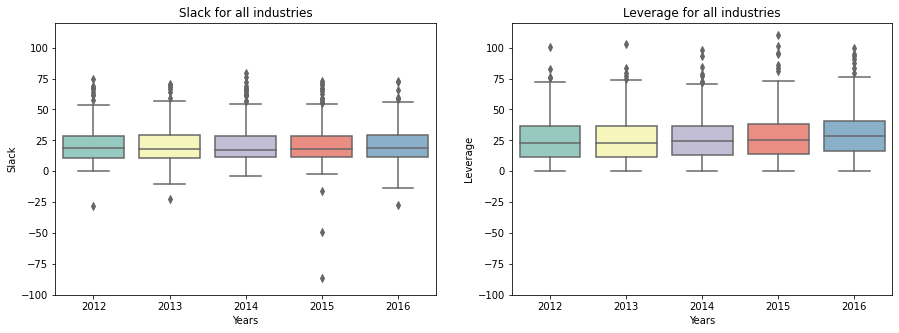

In [176]:
# create boxplots for all industries
create_subplots(new_env_df, new_soc_df, 'year_score', ['slack', 'leverage'],
                'Years', 'Slack', 'Leverage',
                'Slack for all industries',
                'Leverage for all industries', axis_lim=(-100, 120))


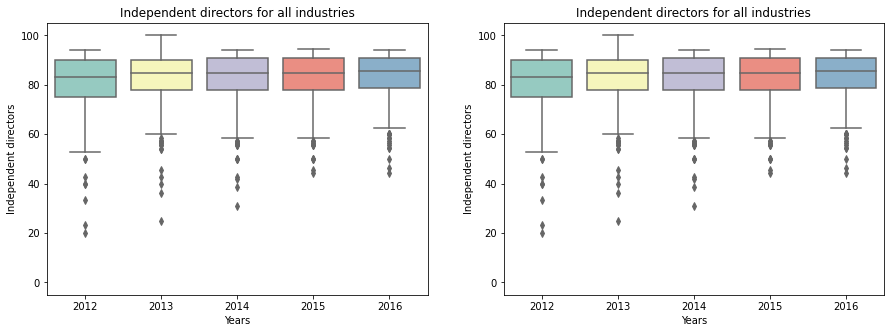

In [177]:
# create boxplots for all industries
create_subplots(new_env_df, new_soc_df, 'year_score', ['independent_dirs', 'independent_dirs'],
                'Years', 'Independent directors', 'Independent directors',
                'Independent directors for all industries',
                'Independent directors for all industries', axis_lim=(-5, 105))


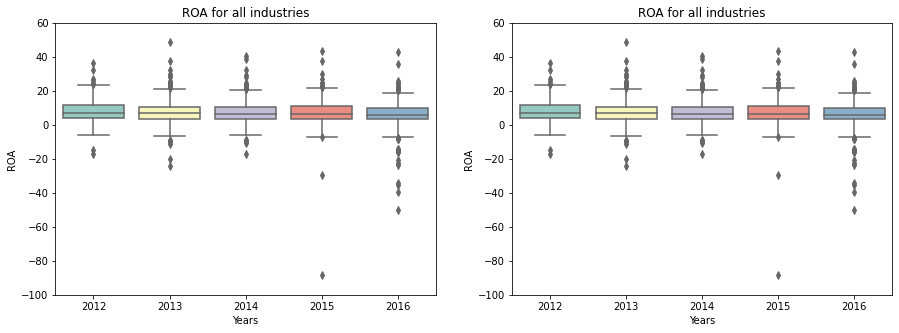

In [178]:
# create boxplots for all industries
create_subplots(new_env_df, new_soc_df, 'year_score', ['roa', 'roa'],
                'Years', 'ROA', 'ROA',
                'ROA for all industries',
                'ROA for all industries', axis_lim=(-100, 60))


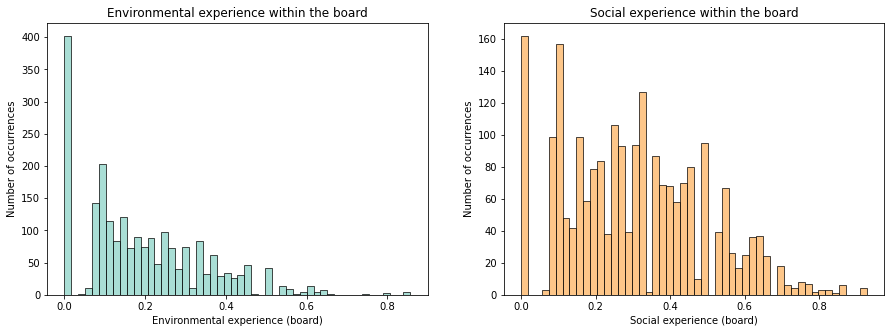

In [179]:
# plot all companies for all years without industry distinction
fig, axes = plt.subplots(1, 2, figsize=(15,5))
# define the first subplots
axes[0] = sb.histplot(x=new_env_df['environmental_exp'], color=palette[0], ax=axes[0], bins=50)
axes[0].set(xlabel='Environmental experience (board)', ylabel='Number of occurrences', title='Environmental experience within the board')

# define the first subplots
axes[1] = sb.histplot(x=new_soc_df['social_exp'], color=palette[5], ax=axes[1], bins=50)
axes[1].set(xlabel='Social experience (board)', ylabel='Number of occurrences', title='Social experience within the board');


In [180]:
# how many boards have no environmental or social experience
print(new_env_df[new_env_df['environmental_exp'] == 0].shape)
print(new_soc_df[new_soc_df['social_exp'] == 0].shape)


(402, 39)
(162, 39)


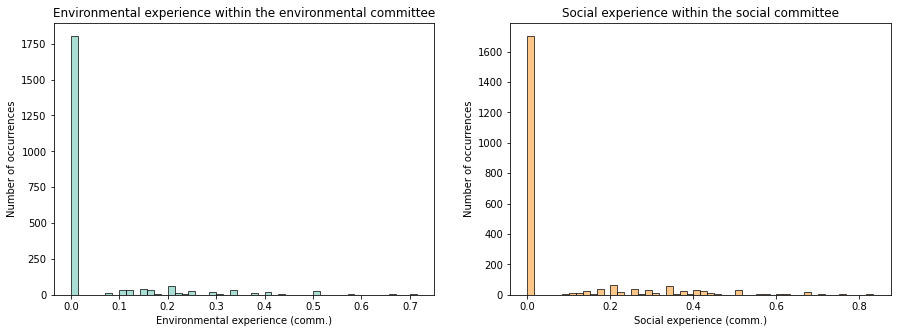

In [181]:
# plot all companies for all years without industry distinction
fig, axes = plt.subplots(1, 2, figsize=(15,5))
# define the first subplots
axes[0] = sb.histplot(x=new_env_df['environmental_comm_exp'], color=palette[0], ax=axes[0], bins=50)
axes[0].set(xlabel='Environmental experience (comm.)', ylabel='Number of occurrences', title='Environmental experience within the environmental committee')

# define the first subplots
axes[1] = sb.histplot(x=new_soc_df['social_comm_exp'], color=palette[5], ax=axes[1], bins=50)
axes[1].set(xlabel='Social experience (comm.)', ylabel='Number of occurrences', title='Social experience within the social committee');


In [182]:
# how many board committees have no environmental or social experience
print(new_env_df[new_env_df['environmental_comm_exp'] == 0].shape)
print(new_soc_df[new_soc_df['social_comm_exp'] == 0].shape)


(1804, 39)
(1703, 39)


In [183]:
# how many boards have environmental or social committees but no one with relevant
# experience on such a committee
print(committee_exp_score[committee_exp_score['environmental_comm_exp'] == 0].shape)
print(committee_exp_score[committee_exp_score['social_comm_exp'] == 0].shape)


(285, 4)
(207, 4)


## With statistics

### Committee statistics

In [184]:
# get all firm-year combinations from the final sample
firm_year_df = new_env_df[['ticker', 'control_year']].copy()


In [185]:
# get the numbers 
only_rel_comps_comm = pd.merge(firm_year_df, absolute_nums_comms, 
                               how='left', on=['ticker', 'control_year'])

only_rel_comps_comm[['social_comm_exp', 'environmental_comm_exp']].fillna(0, inplace=True)
only_rel_comps_comm.describe()


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,control_year,exp_membs_social,comm_membs_social,social_comm_exp,exp_membs_environmental,comm_membs_environmental,environmental_comm_exp
count,2201.000000,696.000000,696.000000,696.000000,671.000000,671.000000,671.000000
mean,2013.025897,1.589080,6.772989,0.227616,1.044709,6.868852,0.148073
std,1.415422,1.428627,2.378601,0.196025,1.142568,2.352026,0.161690
min,2011.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,2012.000000,0.000000,5.000000,0.000000,0.000000,5.000000,0.000000
50%,2013.000000,1.000000,6.500000,0.200000,1.000000,7.000000,0.125000
75%,2014.000000,2.250000,8.000000,0.340909,2.000000,8.000000,0.226496
max,2015.000000,7.000000,13.000000,0.833333,5.000000,13.000000,0.714286


In [186]:
# how many companies have an environmental and/or social committee
print(len(only_rel_comps_comm[only_rel_comps_comm['environmental_comm_exp'].notnull()]['ticker'].unique()))
print(len(only_rel_comps_comm[only_rel_comps_comm['social_comm_exp'].notnull()]['ticker'].unique()))


140
145


In [187]:
# number of companies with committees with only environmental oversight
len(only_rel_comps_comm[(only_rel_comps_comm['environmental_comm_exp'].notnull()) 
                    & (only_rel_comps_comm['social_comm_exp'].isnull())]['ticker'].unique())


1

In [188]:
# number of companies with committees with only social oversight
len(only_rel_comps_comm[(only_rel_comps_comm['social_comm_exp'].notnull()) 
                    & (only_rel_comps_comm['environmental_comm_exp'].isnull())]['ticker'].unique())


6

### Industry statistics

In [189]:
# environmental scores per industry
new_env_df.groupby(['supersector']).mean()[['env_score']].sort_values(by='env_score', ascending=False)


,env_score
supersector,
"food, beverage and tobacco",63.333261
basic resources,59.390145
utilities,58.684399
chemicals,57.029884
"personal care, drug and grocery stores",55.338102
technology,54.869273
travel and leisure,50.467346
real estate,48.096411
industrial goods and services,46.426996


In [190]:
# social scores per industry
new_soc_df.groupby(['supersector']).mean()[['soc_score']].sort_values(by='soc_score', ascending=False)


,soc_score
supersector,
"food, beverage and tobacco",66.723456
"personal care, drug and grocery stores",63.664086
technology,61.659792
chemicals,60.739939
basic resources,58.920589
financial services,58.659574
retailers,58.332352
travel and leisure,57.798260
real estate,57.203273


In [191]:
# average social committee experience per year
new_soc_df.groupby(['year_score']).mean()[['social_comm_exp']].reset_index()


,year_score,social_comm_exp
0,2012,0.066184
1,2013,0.070823
2,2014,0.073742
3,2015,0.075083
4,2016,0.073811


### Score distributions

In [192]:
def dist_plot_statistic_tests_score(df1, df2, col):
    ''' 
    Function to plot the distribution of the performance scores for the datasets 
    with and without experience; this function also performs a mann-whitney u test
    Args: df1 = dataframe; with experience
          df2 = dataframe; with experience
          col = str; column header name
    Returns: None
    '''

    if col == 'env_score':
        xlabel = 'Environmental score'
    else:
        xlabel = 'Social score'

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    # define the first subplots
    sb.histplot(x=df1[col], color=palette[4], ax=axes[0])
    axes[0].set(xlabel=xlabel, ylabel='Number of occurences', title=xlabel+' for companies with experienced directors')

    # define the second subplot
    sb.histplot(x=df2[col], color=palette[0], ax=axes[1])
    axes[1].set(xlabel=xlabel, ylabel='Number of occurences', title=xlabel+' for companies without experienced directors')

    print('Mean of the experienced samples:', df1[col].mean())
    print('Mean of the inexperienced samples:', df2[col].mean())
    print('Standard deviation of the experienced samples:', df1[col].std())
    print('Standard deviation  of the inexperienced samples:', df2[col].std())

    # code adjusted from https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/
    # the mann-whitney u test
    stat, p = mannwhitneyu(df1[col], df2[col])
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')


In [193]:
# check whether the mean environmental score is better for companies with experience than without
env_exp = new_env_df[new_env_df['environmental_exp'] != 0][['env_score']]
no_env_exp = new_env_df[new_env_df['environmental_exp'] == 0][['env_score']]


In [194]:
# check whether the mean environmental score is better for companies with committee experience than without
env_comm_exp = new_env_df[new_env_df['environmental_comm_exp'] != 0][['env_score']]
no_env_comm_exp = new_env_df[new_env_df['environmental_comm_exp'] == 0][['env_score']]


In [195]:
# check whether the mean social score is better for companies with experience than without
soc_exp = new_soc_df[new_soc_df['social_exp'] != 0][['soc_score']]
no_soc_exp = new_soc_df[new_soc_df['social_exp'] == 0][['soc_score']]


In [196]:
# check whether the mean social score is better for companies with committee experience than without
soc_comm_exp = new_soc_df[new_soc_df['social_comm_exp'] != 0][['soc_score']]
no_soc_comm_exp = new_soc_df[new_soc_df['social_comm_exp'] == 0][['soc_score']]


Mean of the experienced samples: 46.74946985491388
Mean of the inexperienced samples: 38.283924115283334
Standard deviation of the experienced samples: 28.25002749554815
Standard deviation  of the inexperienced samples: 26.14369499340753
stat=297016.000, p=0.000
Probably different distributions


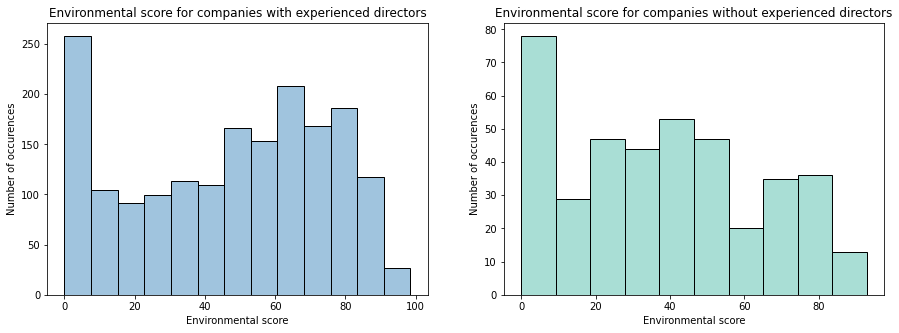

In [197]:
# difference in means for environmental score
dist_plot_statistic_tests_score(env_exp, no_env_exp, 'env_score')


Mean of the experienced samples: 62.74975488789607
Mean of the inexperienced samples: 41.34189638183987
Standard deviation of the experienced samples: 21.579570417891926
Standard deviation  of the inexperienced samples: 27.855631108363102
stat=199746.500, p=0.000
Probably different distributions


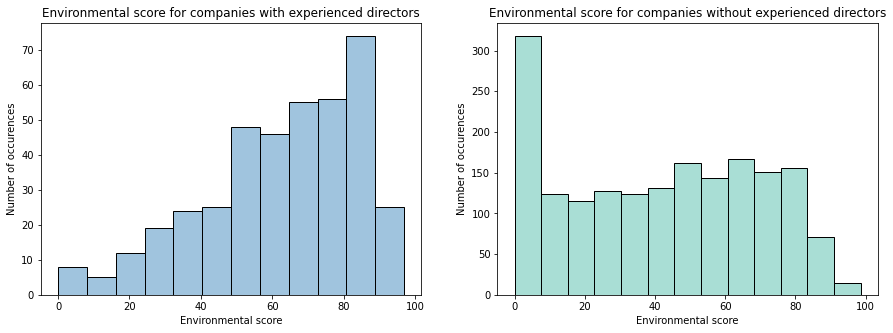

In [198]:
# difference in means for environmental score
dist_plot_statistic_tests_score(env_comm_exp, no_env_comm_exp, 'env_score')


Mean of the experienced samples: 55.480391760447304
Mean of the inexperienced samples: 47.97873700931197
Standard deviation of the experienced samples: 19.921859126449906
Standard deviation  of the inexperienced samples: 20.75948765480628
stat=128586.000, p=0.000
Probably different distributions


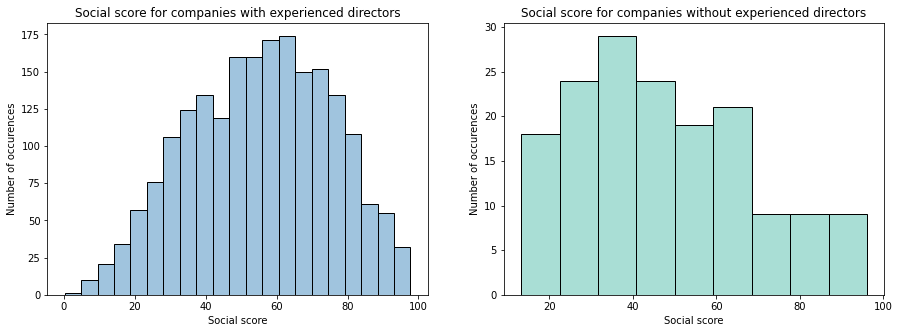

In [199]:
# difference in means for social score
dist_plot_statistic_tests_score(soc_exp, no_soc_exp, 'soc_score')


Mean of the experienced samples: 66.59652405043468
Mean of the inexperienced samples: 51.516151038135156
Standard deviation of the experienced samples: 17.37632520113301
Standard deviation  of the inexperienced samples: 19.5270204567774
stat=238448.000, p=0.000
Probably different distributions


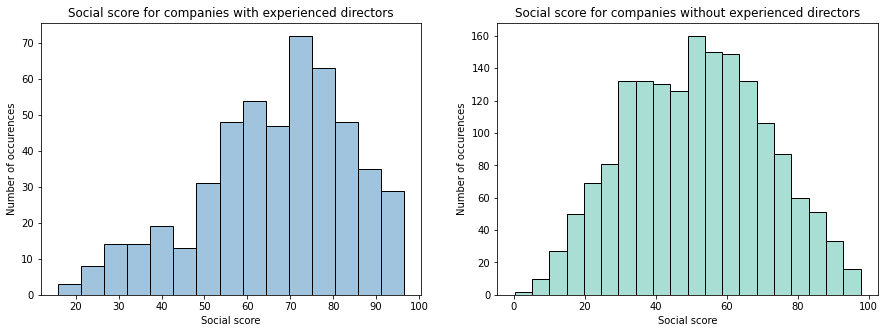

In [200]:
# difference in means for social score
dist_plot_statistic_tests_score(soc_comm_exp, no_soc_comm_exp, 'soc_score')
